In [3452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

# CREATION FONCTIONS

## FONCTION SCORE

In [3453]:
def score(y_train,y_pred_train,y_test,y_pred_test,y,y_pred):
    from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score


    train_score = f'{r2_score( y_train,y_pred_train):.2f}'
    train_mae = f'{mean_absolute_error( y_train,y_pred_train):.2e}'
    train_mse = f'{mean_squared_error( y_train,y_pred_train):.2e}'
    train_mape = f'{mean_absolute_percentage_error( y_train,y_pred_train)*100:.2f}'

    test_score = f'{r2_score(y_test, y_pred_test):.2f}'
    test_mae = f'{mean_absolute_error(y_test, y_pred_test):.2e}'
    test_mse = f'{mean_squared_error(y_test, y_pred_test):.2e}'
    test_mape = f'{mean_absolute_percentage_error(y_test, y_pred_test)*100:.2f}'

    general_score = f'{r2_score(y, y_pred):.2f}'
    general_mae = f'{mean_absolute_error(y, y_pred):.2e}'
    general_mse = f'{mean_squared_error(y, y_pred):.2e}'
    general_mape = f'{mean_absolute_percentage_error(y, y_pred)*100:.2f}'

    return train_score,train_mae,train_mse,train_mape,\
    test_score,test_mae,test_mse,test_mape,\
    general_score,general_mae,general_mse,general_mape


## FONCTION POUR LA REG LIN

In [3454]:
def reg_lin(DF,col_num,target,type,col_a_log):

    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    from sklearn.preprocessing import RobustScaler

    X=DF[col_num]
    y_original=DF[target]
    if type=='RAS':
        y=y_original
    elif type=='log_target':
        y=np.log(y_original)
    elif type=='log_target_feature':
        y=np.log(y_original)
        X[col_a_log]=np.log(X[col_a_log])
    
    #Standardisation des features
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


    #train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



    # Créer et entraîner un modèle de régression linéaire
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)

    # Prédictions
    if type=='RAS':
        y_pred_linear = linear_reg.predict(X_test)
        y_pred_linear_train=linear_reg.predict(X_train)
        y_pred_linear_general=linear_reg.predict(X_scaled)
    else:
        y_pred_linear = np.exp(linear_reg.predict(X_test))
        y_pred_linear_train=np.exp(linear_reg.predict(X_train))
        y_pred_linear_general=np.exp(linear_reg.predict(X_scaled))
    # Évaluation
    if type!='RAS':
        y_test=np.exp(y_test)
        y_train=np.exp(y_train)
        
    
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    r2_linear = r2_score(y_test, y_pred_linear)
    mae_linear= mean_absolute_error(y_test,y_pred_linear)
    mape_linear = mean_absolute_percentage_error(y_test,y_pred_linear)

    print(f"Linear Regression R² Score test: {r2_linear:.2f}")
    print(f"Linear Regression MSE test: {mse_linear:.2e}")
    print(f"Linear Regression MAE test: {mae_linear:.2e}")
    print(f"Linear Regression MAPE test: {mape_linear*100:.2f} %")

    mse_linear_train = mean_squared_error(y_train, y_pred_linear_train)
    r2_linear_train = r2_score(y_train, y_pred_linear_train)
    mae_linear_train= mean_absolute_error(y_train,y_pred_linear_train)
    mape_linear_train = mean_absolute_percentage_error(y_train,y_pred_linear_train)

    print(f"Linear Regression R² Score train: {r2_linear_train:.2f}")
    print(f"Linear Regression MSE train: {mse_linear_train:.2e}")
    print(f"Linear Regression MAE train: {mae_linear_train:.2e}")
    print(f"Linear Regression MAPE train: {mape_linear_train*100:.2f} %")
    

    mse_linear_general = mean_squared_error(y_original, y_pred_linear_general)
    r2_linear_general = r2_score(y_original, y_pred_linear_general)
    mae_linear_general= mean_absolute_error(y_original, y_pred_linear_general)
    mape_linear_general = mean_absolute_percentage_error(y_original, y_pred_linear_general)

    print(f"Linear Regression R² Score general: {r2_linear_general:.2f}")
    print(f"Linear Regression MSE general: {mse_linear_general:.2e}")
    print(f"Linear Regression MAE general: {mae_linear_general:.2e}")
    print(f"Linear Regression MAPE general: {mape_linear_general*100:.2f} %")
    

    ### CREATION DE SERIES POUR LES SCORES AFIN DE COMPARER A LA FIN DE L'ETUDE
    mse_scores = pd.Series({
        'test': f'{mse_linear:.2e}',
        'train': f'{mse_linear_train:.2e}',
        'general': f'{mse_linear_general:.2e}'
    })

    # Pour les R²
    r2_scores = pd.Series({
        'test': f'{r2_linear:.2f}',
        'train': f'{r2_linear_train:.2f}',
        'general': f'{r2_linear_general:.2f}'
    })

    # Pour les mae
    mae_scores = pd.Series({
        'test': f'{mae_linear:.2e}',
        'train': f'{mae_linear_train:.2e}',
        'general': f'{mae_linear_general:.2e}'
    })

    # Pour les mape
    mape_scores = pd.Series({
        'test': f'{mape_linear*100:.2f}',
        'train': f'{mape_linear_train*100:.2f}',
        'general': f'{mape_linear_general*100:.2f}'
    })


    return X_test,y_test,y_pred_linear,y_pred_linear_train,y_pred_linear_general,mse_scores,r2_scores,\
    mape_scores,mae_scores,linear_reg


##  FONCTION DE REPRESENTATION DES PREDICTIONS

In [3455]:
def representation_predictions(y_test,y_pred,y_pred_linear):

    ### REPRESENTATION LINEAIRE VS DUMMY
    print('Représentation des prédictions linéaires et des prédictions dummy')
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Dummy Predictions')
    plt.scatter(y_test, y_pred_linear, color='red', label='Linear Regression Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    plt.title('Comparaison des prédictions: Dummy vs Linear Regression')
    plt.legend()
    plt.show()

    

## FONCTION POUR L'ANALYSE DES HYPOTHESES DE LA REG LIN (PLOT DES RESIDUS/ DURBIN-WATSON/ BREUSCH-PAGAN/ QQ-PLOT/ DISTANCE DE COOK)

In [3456]:
def suite_hypothéses(X_test,y_test,y_pred_linear):
    
    import statsmodels.api as sm


    # Plot des résidus vs valeurs prédites
    print('0) Plot des résidus vs valeurs prédites')
    residus = y_test - y_pred_linear
    plt.scatter(y_pred_linear, residus)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Résidus')
    plt.title('Résidus vs Valeurs prédites')
    plt.show()




    ### DURBIN-WATSON
    print()
    print ('1) Indépendance des résidus (Test de Durbin-Watson)')
    from statsmodels.stats.stattools import durbin_watson
    dw_test = durbin_watson(residus)
    print(f"Durbin-Watson test: {dw_test}")
    if dw_test<1 or dw_test>3:
        print('Probléme')
    else:
        print('Plutot bon')


    ### HOMOSCEDASTICITE
    from statsmodels.stats.diagnostic import het_breuschpagan
    print()
    print("2) Etude de l'homoscedasticité")
    # Ajouter une constante à X
    X_avec_constante = sm.add_constant(X_test)

    # Calculer les résidus 
    residus = y_test - y_pred_linear

    # Effectuer le test de Breusch-Pagan
    test_stat, p_value, f_stat, fp_value = het_breuschpagan(residus, X_avec_constante)

    print('Statistiques du test de Breusch-Pagan:')
    print(f'p-value : {p_value:.4f}')
    print(f'statistique de test : {test_stat:.4f}')

    # Interprétation
    if p_value < 0.05:
        print("Il y a de l'hétéroscédasticité (rejet de H0)")
    else:
        print("Pas d'évidence d'hétéroscédasticité (non rejet de H0)")

    
    ### QQ-plot
    print()
    print("3) QQ-plot")
    plt.figure(figsize=(10,6))
    stats.probplot(residus, dist="norm", plot=plt)
    plt.title("Q-Q plot des résidus")
    plt.show()

    # Test de Shapiro-Wilk
    _, p_value = stats.shapiro(residus)
    print(f"p-value du test Shapiro-Wilk : {p_value}")
    if p_value < 0.05 : 
        print('résidus non normaux')
    else:
        print('résidus normaux')

    
    ### VALEURS ABERRANTES (DISTANCE DE COOK)
    print()
    print("4) Etude des valeurs aberrantes (Distance de Cook)")
    from statsmodels.stats.outliers_influence import OLSInfluence
    import statsmodels.api as sm

    # Ajuster le modèle avec statsmodels
    X_sm = sm.add_constant(X_test)
    model_sm = sm.OLS(y_test, X_sm).fit()

    # Calculer les distances de Cook
    influence = model_sm.get_influence()
    cook_distance = influence.cooks_distance[0]

    # Plot
    plt.stem(range(len(cook_distance)), cook_distance, markerfmt=',')
    plt.xlabel("Index d'observation")
    plt.ylabel("Distance de Cook")
    plt.show()
        


## FONCTION REGRESSION REGULARISEE (LASSO,RIDGE,ELASTICNET)

In [3457]:
def reg_regul(DF,col_num,target,type,log_feature,alpha=1.0,l1_ratio=0.5):
    from sklearn.linear_model import Ridge, Lasso, ElasticNet
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
    import numpy as np
    import matplotlib.pyplot as plt

    X=DF[col_num]
    y=DF[target]

    if type!='RAS':
        y=np.log(y)
        if type=='log_target_feature':
            for col in log_feature:
                X[col]=np.log(X[col])



    # 1. Préparation des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_scaled = scaler.transform(X)  # Pour l'évaluation générale

    # 3. Modèles avec régularisation
    # Ridge (L2)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)

    # Lasso (L1)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)

    # ElasticNet (L1 + L2)
    elastic = ElasticNet(alpha=alpha,fit_intercept= True, l1_ratio=l1_ratio,max_iter=1000,random_state=42,selection='cyclic',tol=0.01)
    elastic.fit(X_train_scaled, y_train)

    # 4. Prédictions
    # Train
    y_pred_train_ridge = ridge.predict(X_train_scaled)
    y_pred_train_lasso = lasso.predict(X_train_scaled)
    y_pred_train_elastic = elastic.predict(X_train_scaled)

    if type!='RAS':
        y_pred_train_ridge=np.exp(y_pred_train_ridge)
        y_pred_train_lasso=np.exp(y_pred_train_lasso)
        y_pred_train_elastic=np.exp(y_pred_train_elastic)
    
    # Test
    y_pred_test_ridge = ridge.predict(X_test_scaled)
    y_pred_test_lasso = lasso.predict(X_test_scaled)
    y_pred_test_elastic = elastic.predict(X_test_scaled)

    if type!='RAS':
        y_pred_test_ridge=np.exp(y_pred_test_ridge)
        y_pred_test_lasso=np.exp(y_pred_test_lasso)
        y_pred_test_elastic=np.exp(y_pred_test_elastic)

    # Général
    y_pred_general_ridge = ridge.predict(X_scaled)
    y_pred_general_lasso = lasso.predict(X_scaled)
    y_pred_general_elastic = elastic.predict(X_scaled)

    if type!='RAS':
        y_pred_general_ridge=np.exp(y_pred_general_ridge)
        y_pred_general_lasso=np.exp(y_pred_general_lasso)
        y_pred_general_elastic=np.exp(y_pred_general_elastic)

    # 5. Fonction d'évaluation améliorée
    def evaluate_model(model_name, y_true_train, y_pred_train, 
                    y_true_test, y_pred_test, y_true_general, y_pred_general,type):
        # Suffix pour les noms selon le type de transformation
        suffix = "" if type == "RAS" else f"_{type}"
        
        # Création du dictionnaire des métriques
        metrics = {
            f'r2_{model_name}{suffix}': {
                'train': f'{r2_score(y_true_train, y_pred_train):.2f}',
                'test': f'{r2_score(y_true_test, y_pred_test):.2f}',
                'general': f'{r2_score(y_true_general, y_pred_general):.2f}'
            },
            f'mse_{model_name}{suffix}': {
                'train': f'{mean_squared_error(y_true_train, y_pred_train):.2e}',
                'test': f'{mean_squared_error(y_true_test, y_pred_test):.2e}',
                'general': f'{mean_squared_error(y_true_general, y_pred_general):.2e}'
            },
            f'mae_{model_name}{suffix}': {
                'train': f'{mean_absolute_error(y_true_train, y_pred_train):.2e}',
                'test': f'{mean_absolute_error(y_true_test, y_pred_test):.2e}',
                'general': f'{mean_absolute_error(y_true_general, y_pred_general):.2e}'
            },
            f'mape_{model_name}{suffix}': {
                'train': f'{mean_absolute_percentage_error(y_true_train, y_pred_train)*100:.2f}',
                'test': f'{mean_absolute_percentage_error(y_true_test, y_pred_test)*100:.2f}',
                'general': f'{mean_absolute_percentage_error(y_true_general, y_pred_general)*100:.2f}'
            }
        }
        
        return metrics
    
    if type!='RAS':
        y_train=np.exp(y_train)
        y_test=np.exp(y_test)
        y=np.exp(y)

    # Dans la fonction principale
    all_metrics = {}

    # Pour chaque modèle
    for model_name, predictions in [("Ridge", [y_pred_train_ridge, y_pred_test_ridge, y_pred_general_ridge]),
                                ("Lasso", [y_pred_train_lasso, y_pred_test_lasso, y_pred_general_lasso]),
                                ("ElasticNet", [y_pred_train_elastic, y_pred_test_elastic, y_pred_general_elastic])]:
        metrics = evaluate_model(model_name, 
                            y_train, predictions[0],
                            y_test, predictions[1],
                            y, predictions[2],
                            type)
        all_metrics.update(metrics)

    # Création du DataFrame avec le format souhaité
    results_df = pd.DataFrame.from_dict(all_metrics, orient='index',\
                                         columns=['train', 'test', 'general']).sort_index()

    return ridge, lasso, elastic, results_df,y_test,y_pred_test_elastic,scaler

## FONCTION DECISION TREE

In [3458]:
def decision_tree_regressor(DF,col_num,target,type,col_a_log,MAE,MAPE,MSE,R2):

    from sklearn.tree import DecisionTreeRegressor, plot_tree
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score

    X=DF[col_num]
    y=DF[target]

    if type!='RAS':
        y=np.log(y)
        if type=='log_target_feature':
            for col in col_a_log:
                X[col]=np.log(X[col])


    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

    # Création du modèle
    dt_reg = DecisionTreeRegressor(
        max_depth=5,                # Limite la profondeur de l'arbre
        min_samples_split=10,        # Minimum d'échantillons pour diviser un nœud
        min_samples_leaf=6,         # Minimum d'échantillons dans une feuille
        random_state=42
    )

    # Entraînement
    dt_reg.fit(X_train, y_train)

    # Prédictions
    y_pred_test = dt_reg.predict(X_test)
    y_pred_train=dt_reg.predict(X_train)
    y_pred=dt_reg.predict(X)
    if type!='RAS':
        y_pred_test=np.exp(y_pred_test)
        y_train=np.exp(y_train)
        y_pred_train=np.exp(y_pred_train)
        y_test=np.exp(y_test)
        y=np.exp(y)
        y_pred=np.exp(y_pred)


    # Score

    train_score,train_mae,train_mse,train_mape,test_score,test_mae,test_mse,test_mape,\
    general_score,general_mae,general_mse,general_mape=\
    score(y_train,y_pred_train,y_test,y_pred_test,y,y_pred)



    


    print(f"Score R² train : {train_score}")
    print(f"Score R² test : {test_score}")
    print(f"Score MAE train : {train_mae}")
    print(f"Score MAE test : {test_mae}")
    print(f"Score MAPE train : {train_mape} %")
    print(f"Score MAPE test : {test_mape} %")
    print(f"Score MSE train : {train_mse}")
    print(f"Score MSE test : {test_mse}")

    mae=pd.Series([train_mae,test_mae,general_mae],index=['train','test','general'])
    mse=pd.Series([train_mse,test_mse,general_mse],index=['train','test','general'])
    mape=pd.Series([train_mape,test_mape,general_mape],index=['train','test','general'])
    r2=pd.Series([train_score,test_score,general_score],index=['train','test','general'])


    nouvelle_ligne=mae
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Decision Tree']

    MAE=pd.concat([MAE,nouvelle_ligne])

    nouvelle_ligne=mape
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Decision Tree']

    MAPE=pd.concat([MAPE,nouvelle_ligne])

    nouvelle_ligne=mse
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Decision Tree']

    MSE=pd.concat([MSE,nouvelle_ligne])

    nouvelle_ligne=r2
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Decision Tree']

    R2=pd.concat([R2,nouvelle_ligne])


    # Visualisation de l'arbre
    plt.figure(figsize=(40,20))  # Taille doublée
    plot_tree(dt_reg, 
            feature_names=X_train.columns, 
            filled=True,
            fontsize=12,         # Taille de la police
            max_depth=5,         # Limite la visualisation aux 5 premiers niveaux
            precision=2)         # Nombre de décimales affichées
    plt.show()

    return dt_reg,MAE,MAPE,MSE,R2

## FONCTION RANDOM FOREST

In [3459]:
def random_forest(DF,col_num,target,type,col_a_log,MAE,MAPE,MSE,R2,verbose=True,params=\
                  {'n_estimators':75,'max_depth':10,'min_samples_split':8,'min_samples_leaf':5,'random_state':42}):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score


    X=DF[col_num]
    y=DF[target]

    if type!='RAS':
        
        y=np.log(y)
        if type=='log_target_feature':
            for col in col_a_log:
                X[col]=np.log(X[col])


    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


    # Création du modèle
    rf_reg = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],           # même profondeur que notre meilleur Decision Tree
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=params['random_state']
    )

    # Entraînement
    rf_reg.fit(X_train, y_train)

    y_pred_test =rf_reg.predict(X_test)
    y_pred_train=rf_reg.predict(X_train)
    y_pred=rf_reg.predict(X)
    
    if type!='RAS':
        y_pred_test=np.exp(y_pred_test)
        y_train=np.exp(y_train)
        y_test=np.exp(y_test)
        y_pred_train=np.exp(y_pred_train)
        y=np.exp(y)
        y_pred=np.exp(y_pred)
    
    
    
    
    # Score
    train_score,train_mae,train_mse,train_mape,test_score,test_mae,test_mse,test_mape,\
    general_score,general_mae,general_mse,general_mape=\
    score(y_train,y_pred_train,y_test,y_pred_test,y,y_pred)


    if verbose:
        print(f"Score R² train : {train_score}")
        print(f"Score R² test : {test_score}")
        print(f"Score MAE train : {train_mae}")
        print(f"Score MAE test : {test_mae}")
        print(f"Score MAPE train : {train_mape} %")
        print(f"Score MAPE test : {test_mape} %")
        print(f"Score MSE train : {train_mse}")
        print(f"Score MSE test : {test_mse}")

    mae=pd.Series([train_mae,test_mae,general_mae],index=['train','test','general'])
    mse=pd.Series([train_mse,test_mse,general_mse],index=['train','test','general'])
    mape=pd.Series([train_mape,test_mape,general_mape],index=['train','test','general'])
    r2=pd.Series([train_score,test_score,general_score],index=['train','test','general'])


    nouvelle_ligne=mae
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Random Forest']

    MAE=pd.concat([MAE,nouvelle_ligne])

    nouvelle_ligne=mape
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Random Forest']

    MAPE=pd.concat([MAPE,nouvelle_ligne])

    nouvelle_ligne=mse
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Random Forest']

    MSE=pd.concat([MSE,nouvelle_ligne])

    nouvelle_ligne=r2
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Random Forest']

    R2=pd.concat([R2,nouvelle_ligne])

    # Feature importance
    #feature_importance = pd.DataFrame({
     #   'feature': X_train.columns,
      #  'importance': rf_reg.feature_importances_
    #})
    #print("\nImportance des features :")
    #print(feature_importance.sort_values('importance', ascending=False))

    return rf_reg,MAE,MAPE,MSE,R2

## FONCTION GRADIENT BOOSTING

In [3460]:
def gradient_boosting(DF,col_num,target,type,col_a_log,MAE,MAPE,MSE,R2,verbose=True):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score


    X=DF[col_num]
    y=DF[target]

    if type!='RAS':
        
        y=np.log(y)
        if type=='log_target_feature':
            for col in col_a_log:
                X[col]=np.log(X[col])


    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


    # Création du modèle
    gb_reg = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,     # learning rate réduit
        min_samples_split=12,   # augmenté
        min_samples_leaf=8,     # augmenté
        subsample=0.7,         # réduit pour plus de randomisation
        random_state=42
    )

    # Entraînement avec données log
    gb_reg.fit(X_train, y_train)

    y_pred_test=gb_reg.predict(X_test)
    y_pred_train=gb_reg.predict(X_train)
    y_pred=gb_reg.predict(X)
    
    if type!='RAS':
        y=np.exp(y)
        y_pred_test=np.exp(y_pred_test)
        y_pred_train=np.exp(y_pred_train)
        y_pred=np.exp(y_pred)
        y_train=np.exp(y_train)
        y_test=np.exp(y_test)
    
    
    
    # Score
    train_score,train_mae,train_mse,train_mape,test_score,test_mae,test_mse,test_mape,\
    general_score,general_mae,general_mse,general_mape=\
    score(y_train,y_pred_train,y_test,y_pred_test,y,y_pred)

    if verbose:
        print(f"Score R² train : {train_score}")
        print(f"Score R² test : {test_score}")
        print(f"Score MAE train : {train_mae}")
        print(f"Score MAE test : {test_mae}")
        print(f"Score MAPE train : {train_mape} %")
        print(f"Score MAPE test : {test_mape} %")
        print(f"Score MSE train : {train_mse}")
        print(f"Score MSE test : {test_mse}")

    mae=pd.Series([train_mae,test_mae,general_mae],index=['train','test','general'])
    mse=pd.Series([train_mse,test_mse,general_mse],index=['train','test','general'])
    mape=pd.Series([train_mape,test_mape,general_mape],index=['train','test','general'])
    r2=pd.Series([train_score,test_score,general_score],index=['train','test','general'])


    nouvelle_ligne=mae
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Gradient Boosting']

    MAE=pd.concat([MAE,nouvelle_ligne])

    nouvelle_ligne=mape
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Gradient Boosting']

    MAPE=pd.concat([MAPE,nouvelle_ligne])

    nouvelle_ligne=mse
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Gradient Boosting']

    MSE=pd.concat([MSE,nouvelle_ligne])

    nouvelle_ligne=r2
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['Gradient Boosting']

    R2=pd.concat([R2,nouvelle_ligne])




    # Feature importance
    #feature_importance = pd.DataFrame({
     #   'feature': X_train_log.columns,
      #  'importance': gb_reg.feature_importances_
    #})
    #print("\nImportance des features :")
    #print(feature_importance.sort_values('importance', ascending=False))

    return gb_reg,MAE,MAPE,MSE,R2

## FONCTION XGBOOST

In [3461]:
def xgboost_reg(DF,col_num,target,type,col_a_log,MAE,MAPE,MSE,R2):

    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score



    X=DF[col_num]
    y=DF[target]

    if type!='RAS':
        y=np.log(y)
        if type=='log_target_feature':
            for col in col_a_log:
                X[col]=np.log(X[col])
    
    

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


    # Création du modèle
    xgb_reg = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,     # même learning rate que notre meilleur GB
        min_child_weight=6,     # équivalent à min_samples_leaf
        subsample=0.7,          # même que notre meilleur GB
        colsample_bytree=0.8,   # échantillonnage des features
        reg_alpha=0.1,          # régularisation L1
        reg_lambda=1,           # régularisation L2
        random_state=42
    )

    # Entraînement avec données log
    xgb_reg.fit(X_train, y_train)

    y_pred_test=xgb_reg.predict(X_test)
    y_pred_train=xgb_reg.predict(X_train)
    y_pred=xgb_reg.predict(X)

    if type!='RAS':
        y=np.exp(y)
        y_train=np.exp(y_train)
        y_test=np.exp(y_test)
        y_pred_test=np.exp(y_pred_test)
        y_pred_train=np.exp(y_pred_train)
        y_pred=np.exp(y_pred)
    
    
    
    
    
    
    # Score
    train_score,train_mae,train_mse,train_mape,test_score,test_mae,test_mse,test_mape,\
    general_score,general_mae,general_mse,general_mape=\
    score(y_train,y_pred_train,y_test,y_pred_test,y,y_pred)



    print(f"Score R² train : {train_score}")
    print(f"Score R² test : {test_score}")
    print(f"Score MAE train : {train_mae}")
    print(f"Score MAE test : {test_mae}")
    print(f"Score MAPE train : {train_mape} %")
    print(f"Score MAPE test : {test_mape} %")
    print(f"Score MSE train : {train_mse}")
    print(f"Score MSE test : {test_mse}")

    mae=pd.Series([train_mae,test_mae,general_mae],index=['train','test','general'])
    mse=pd.Series([train_mse,test_mse,general_mse],index=['train','test','general'])
    mape=pd.Series([train_mape,test_mape,general_mape],index=['train','test','general'])
    r2=pd.Series([train_score,test_score,general_score],index=['train','test','general'])


    nouvelle_ligne=mae
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['XGBoost']

    MAE=pd.concat([MAE,nouvelle_ligne])

    nouvelle_ligne=mape
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['XGBoost']

    MAPE=pd.concat([MAPE,nouvelle_ligne])

    nouvelle_ligne=mse
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['XGBoost']

    MSE=pd.concat([MSE,nouvelle_ligne])

    nouvelle_ligne=r2
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['XGBoost']

    R2=pd.concat([R2,nouvelle_ligne])


    # Feature importance
    #feature_importance = pd.DataFrame({
     #   'feature': X_train_log.columns,
      #  'importance': xgb_reg.feature_importances_
    #})
    #print("\nImportance des features :")
    #print(feature_importance.sort_values('importance', ascending=False))

    return xgb_reg,MAE,MAPE,MSE,R2

## FONCTION SVR

In [3462]:
def svr_reg(DF,col_num,target,type,col_a_log,MAE,MAPE,MSE,R2):
    from sklearn.svm import SVR
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score



    X=DF[col_num]
    y=DF[target]

    if type!='RAS':
    
        y=np.log(y)
        if type=='log_target_feature':
            for col in col_a_log:
                X[col]=np.log(X[col])


    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


    # Scaling des données log-transformées
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_scaled= scaler.transform(X)

    # Scaling de y aussi
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

    # Création du modèle
    svr = SVR(
        kernel='rbf',
        C=1.0,
        epsilon=0.1,
        gamma='scale'
    )

    # Entraînement
    svr.fit(X_train_scaled, y_train_scaled)

    # Prédictions
    y_train_pred_scaled = svr.predict(X_train_scaled)
    y_test_pred_scaled = svr.predict(X_test_scaled)
    y_pred_scaled = svr.predict(X_scaled)

    # Retransformation pour calculer le R²
    y_pred_train = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
    y_pred_test = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

    if type!='RAS':
        y=np.exp(y)
        y_train=np.exp(y_train)
        y_test=np.exp(y_test)

        y_pred_train=np.exp(y_pred_train)
        y_pred_test=np.exp(y_pred_test)
        y_pred = np.exp(y_pred)

    # Score
    train_score,train_mae,train_mse,train_mape,test_score,test_mae,test_mse,test_mape,\
    general_score,general_mae,general_mse,general_mape=\
    score(y_train,y_pred_train,y_test,y_pred_test,y,y_pred)



    print(f"Score R² train : {train_score}")
    print(f"Score R² test : {test_score}")
    print(f"Score MAE train : {train_mae}")
    print(f"Score MAE test : {test_mae}")
    print(f"Score MAPE train : {train_mape} %")
    print(f"Score MAPE test : {test_mape} %")
    print(f"Score MSE train : {train_mse}")
    print(f"Score MSE test : {test_mse}")

    mae=pd.Series([train_mae,test_mae,general_mae],index=['train','test','general'])
    mse=pd.Series([train_mse,test_mse,general_mse],index=['train','test','general'])
    mape=pd.Series([train_mape,test_mape,general_mape],index=['train','test','general'])
    r2=pd.Series([train_score,test_score,general_score],index=['train','test','general'])


    nouvelle_ligne=mae
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['SVR']

    MAE=pd.concat([MAE,nouvelle_ligne])

    nouvelle_ligne=mape
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['SVR']

    MAPE=pd.concat([MAPE,nouvelle_ligne])

    nouvelle_ligne=mse
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['SVR']

    MSE=pd.concat([MSE,nouvelle_ligne])

    nouvelle_ligne=r2
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['SVR']

    R2=pd.concat([R2,nouvelle_ligne])

    return MAE,MAPE,MSE,R2

## FONCTION NEURAL NETWORK

In [3463]:
def nn_reg_fonc(DF,col_num,target,type,col_a_log,MAE,MAPE,MSE,R2):

    from sklearn.neural_network import MLPRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score




    X=DF[col_num]
    y=DF[target]

    if type!='RAS':
    
        y=np.log(y)
        if type=='log_target_feature':
            for col in col_a_log:
                X[col]=np.log(X[col])


    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


    # Scaling des données log-transformées
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_scaled = scaler.transform(X)

    # Scaling de y aussi
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

    # Création du modèle
    nn_reg = MLPRegressor(
        hidden_layer_sizes=(64, 48, 32, 16),  # Architecture qui marchait bien
        activation='relu',
        solver='adam',
        alpha=0.01,                     # Réduit de 0.05 à 0.01
        batch_size=64,                  # Augmenté à 64
        learning_rate='constant',       # Changé de 'adaptive' à 'constant'
        learning_rate_init=0.003,       # Réduit à 0.003
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=15,           # Augmenté à 15
        max_iter=1500,                 # Augmenté à 1500
        random_state=42
    )

    # Entraînement
    nn_reg.fit(X_train_scaled, y_train_scaled)

    # Prédictions
    y_train_pred_scaled = nn_reg.predict(X_train_scaled)
    y_test_pred_scaled = nn_reg.predict(X_test_scaled)
    y_pred_scaled = nn_reg.predict(X_scaled)

    # Retransformation pour les scores
    y_pred_train = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
    y_pred_test = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    if type!='RAS':
        y=np.exp(y)
        y_train=np.exp(y_train)
        y_test=np.exp(y_test)

        y_pred_train=np.exp(y_pred_train)
        y_pred_test=np.exp(y_pred_test)
        y_pred=np.exp(y_pred)



    # Score
    train_score,train_mae,train_mse,train_mape,test_score,test_mae,test_mse,test_mape,\
    general_score,general_mae,general_mse,general_mape=\
    score(y_train,y_pred_train,y_test,y_pred_test,y,y_pred)



    print(f"Score R² train : {train_score}")
    print(f"Score R² test : {test_score}")
    print(f"Score MAE train : {train_mae}")
    print(f"Score MAE test : {test_mae}")
    print(f"Score MAPE train : {train_mape} %")
    print(f"Score MAPE test : {test_mape} %")
    print(f"Score MSE train : {train_mse}")
    print(f"Score MSE test : {test_mse}")

    mae=pd.Series([train_mae,test_mae,general_mae],index=['train','test','general'])
    mse=pd.Series([train_mse,test_mse,general_mse],index=['train','test','general'])
    mape=pd.Series([train_mape,test_mape,general_mape],index=['train','test','general'])
    r2=pd.Series([train_score,test_score,general_score],index=['train','test','general'])


    nouvelle_ligne=mae
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['NN']

    MAE=pd.concat([MAE,nouvelle_ligne])

    nouvelle_ligne=mape
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['NN']

    MAPE=pd.concat([MAPE,nouvelle_ligne])

    nouvelle_ligne=mse
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['NN']

    MSE=pd.concat([MSE,nouvelle_ligne])

    nouvelle_ligne=r2
    nouvelle_ligne=nouvelle_ligne.to_frame().T
    nouvelle_ligne.index=['NN']

    R2=pd.concat([R2,nouvelle_ligne])

    return nn_reg,MAE,MAPE,MSE,R2,scaler,scaler_y

## TABLEAU DES SCORES


In [3464]:
Tableau_score_r2=pd.DataFrame(columns=['train','test','general'])
Tableau_score_mae=pd.DataFrame(columns=['train','test','general'])
Tableau_score_mape=pd.DataFrame(columns=['train','test','general'])
Tableau_score_mse=pd.DataFrame(columns=['train','test','general'])
Tableau_score_feature=pd.DataFrame(columns=['Nbre Feature Pertinentes'])

# DEBUT DE L'ETUDE

In [3465]:
DF_cleaned=pd.read_csv('DF_nettoyé.csv')

In [3466]:
DF_cleaned.head()

,BuildingType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,...,%_elec(kBtu),%_gas(kBtu),%_steam(kBtu),%_parking,%_immeuble,PrimaryPropertyType_Autres,PrimaryPropertyType_Education et Services Communautaires,PrimaryPropertyType_Immobilier Commercial,PrimaryPropertyType_Logistique et Stockage,PrimaryPropertyType_Santé
0,NonResidential,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,...,55.0,18.0,28.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0
1,NonResidential,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1.0,...,39.0,61.0,0.0,15.0,85.0,0.0,0.0,1.0,0.0,0.0
2,NonResidential,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1.0,...,68.0,2.0,30.0,21.0,79.0,0.0,0.0,1.0,0.0,0.0
3,NonResidential,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,...,41.0,27.0,33.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0
4,NonResidential,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1.0,...,38.0,62.0,0.0,35.0,65.0,0.0,0.0,1.0,0.0,0.0


In [3467]:
DF_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 36 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   BuildingType                                              1429 non-null   object 
 1   PropertyName                                              1429 non-null   object 
 2   Address                                                   1429 non-null   object 
 3   ZipCode                                                   1429 non-null   float64
 4   TaxParcelIdentificationNumber                             1429 non-null   object 
 5   CouncilDistrictCode                                       1429 non-null   int64  
 6   Neighborhood                                              1429 non-null   object 
 7   Latitude                                                  1429 non-null   float64
 8   Longitude         

ON VA DROP UNE COLONNE DU ONE HOT POUR LA REGRESSION LINEAIRE CAR SINON VARIABLES TROP CORELLEES

In [3468]:
DF_cleaned_lineaire=DF_cleaned.drop(['PrimaryPropertyType_Autres'],axis=1)

ON VA DROP TOTALGHGEMISSION CAR PAS DISPO LORS DE L'ETUDE

In [3469]:
DF_cleaned_lineaire=DF_cleaned_lineaire.drop(['TotalGHGEmissions'],axis=1)

In [3470]:
DF_cleaned_lineaire.shape

(1429, 34)

In [3471]:
len(DF_cleaned['LargestPropertyUseType'].unique())

50

In [3472]:
col_num=[]
col_obj=[]
for col in DF_cleaned_lineaire.columns:
    if DF_cleaned_lineaire[col].dtype in ['int64','float64'] :
        col_num.append(col)
    else:
        col_obj.append(col)

In [3473]:
colonne_à_retirer=[]
for col in col_num:
    if DF_cleaned_lineaire[col].isna().sum()!=0:
        colonne_à_retirer.append(col)
print(colonne_à_retirer)
for t in colonne_à_retirer:
    del(col_num[col_num.index(t)])

['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore']


# DEFINITION DE LA TARGET

In [3474]:
TARGET='SiteEnergyUseWN(kBtu)'

In [3475]:
DF_cleaned_lineaire[TARGET].describe()

count    1.429000e+03
mean     7.983119e+06
std      1.943532e+07
min      5.811420e+04
25%      1.300766e+06
50%      2.789899e+06
75%      7.250730e+06
max      2.966717e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

# VERIFICATION DES HYPOTHESES DE LA REGRESSION LINEAIRE

## 1) ETUDE DU VIF ( Variance Inflation Factor )

In [3476]:

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

data =DF_cleaned_lineaire[col_num]
X = sm.add_constant(data)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

print("\n Analyse VIF (multicolinéarité)")
vif_data = calculate_vif(X.drop('const', axis=1))
print(vif_data)


 Analyse VIF (multicolinéarité)
                                             Variable           VIF
13                                         %_immeuble  5.411624e+07
12                                          %_parking  1.582587e+06
10                                        %_gas(kBtu)  5.378154e+04
9                                        %_elec(kBtu)  5.361028e+04
11                                      %_steam(kBtu)  6.641156e+03
6                                    PropertyGFATotal  3.323954e+00
15          PrimaryPropertyType_Immobilier Commercial  2.607068e+00
5                                      NumberofFloors  2.552744e+00
7                               SiteEnergyUseWN(kBtu)  2.411290e+00
16         PrimaryPropertyType_Logistique et Stockage  2.228422e+00
1                                 CouncilDistrictCode  2.150013e+00
14  PrimaryPropertyType_Education et Services Comm...  1.748249e+00
2                                            Latitude  1.625938e+00
17             

## 2) SCATTER PLOTS

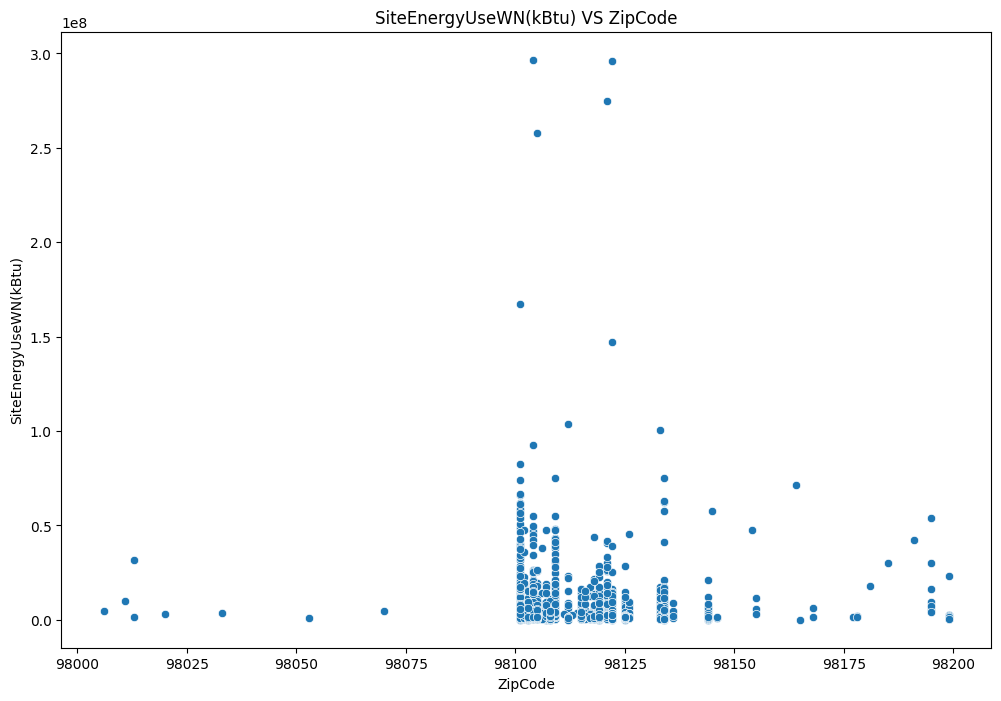

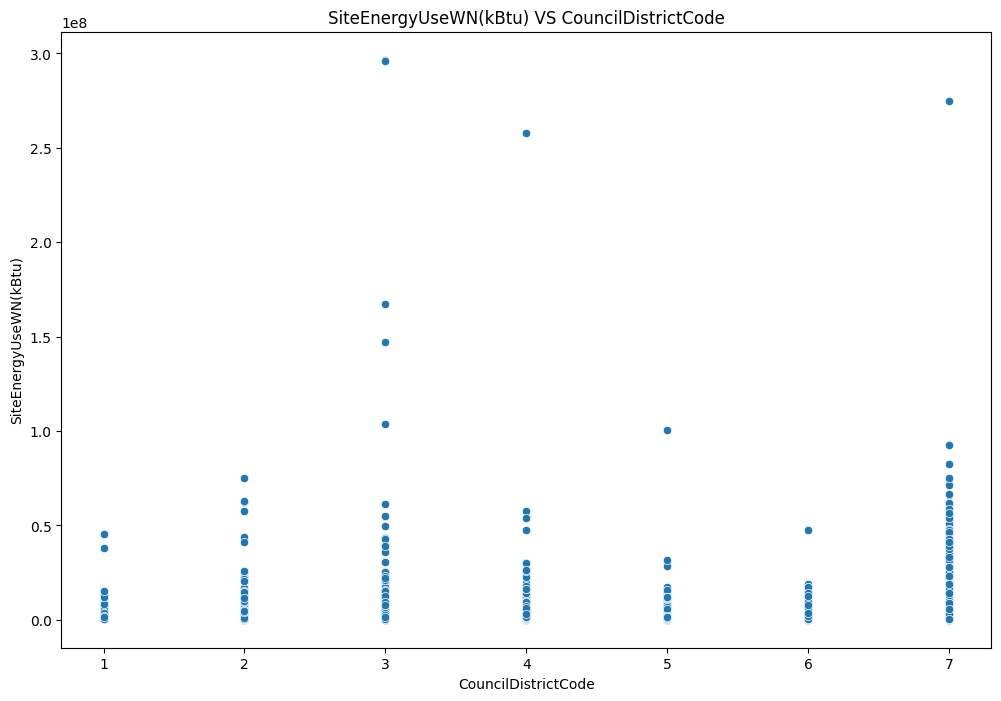

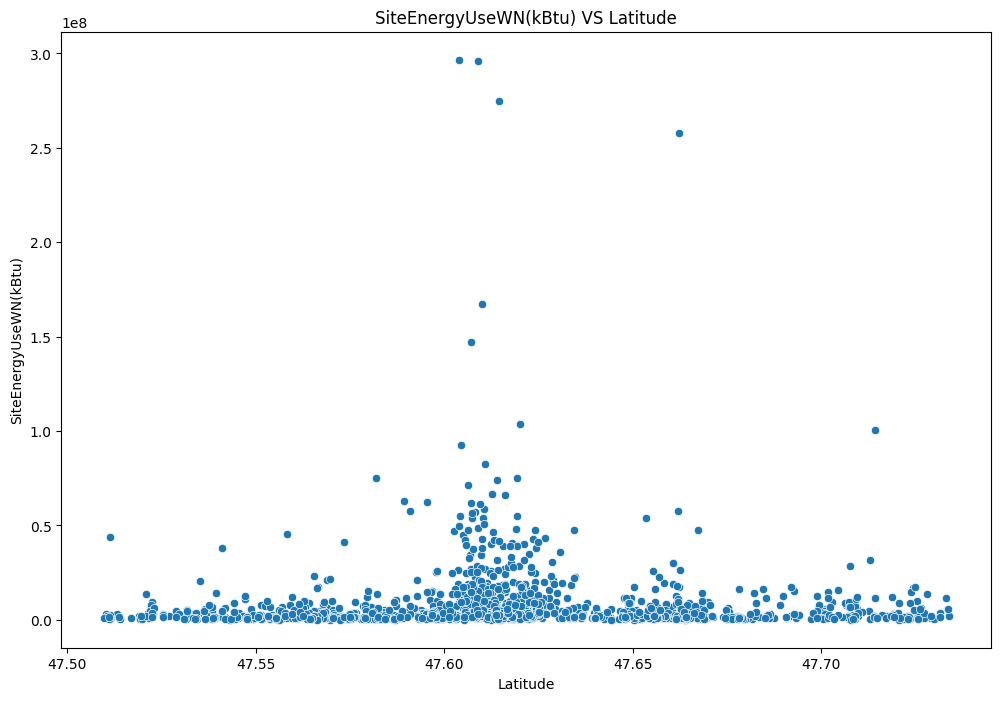

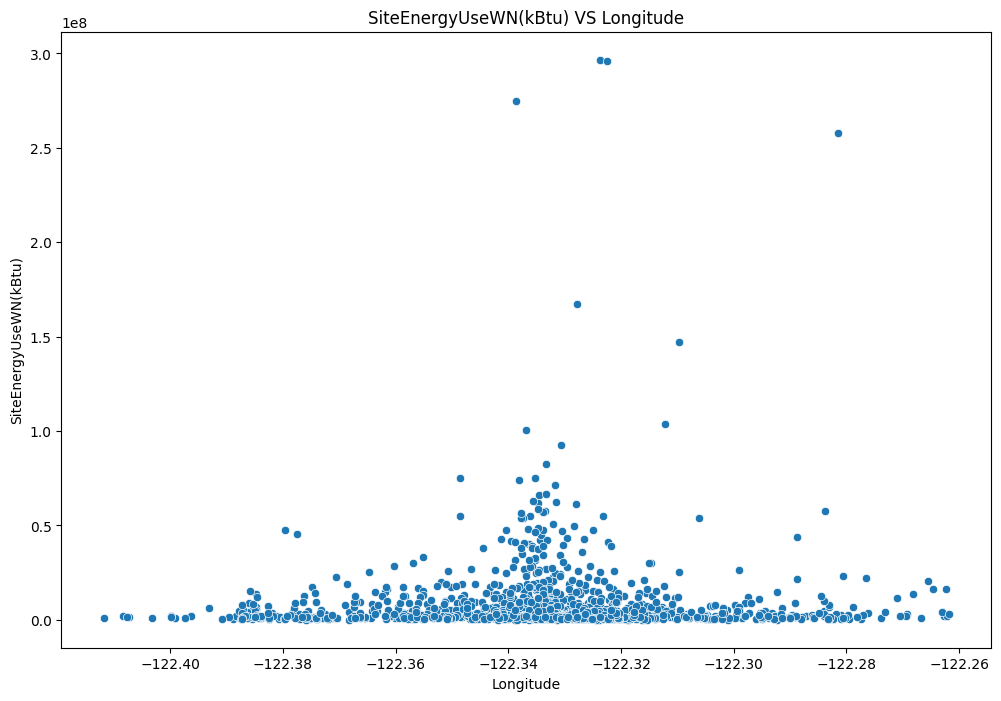

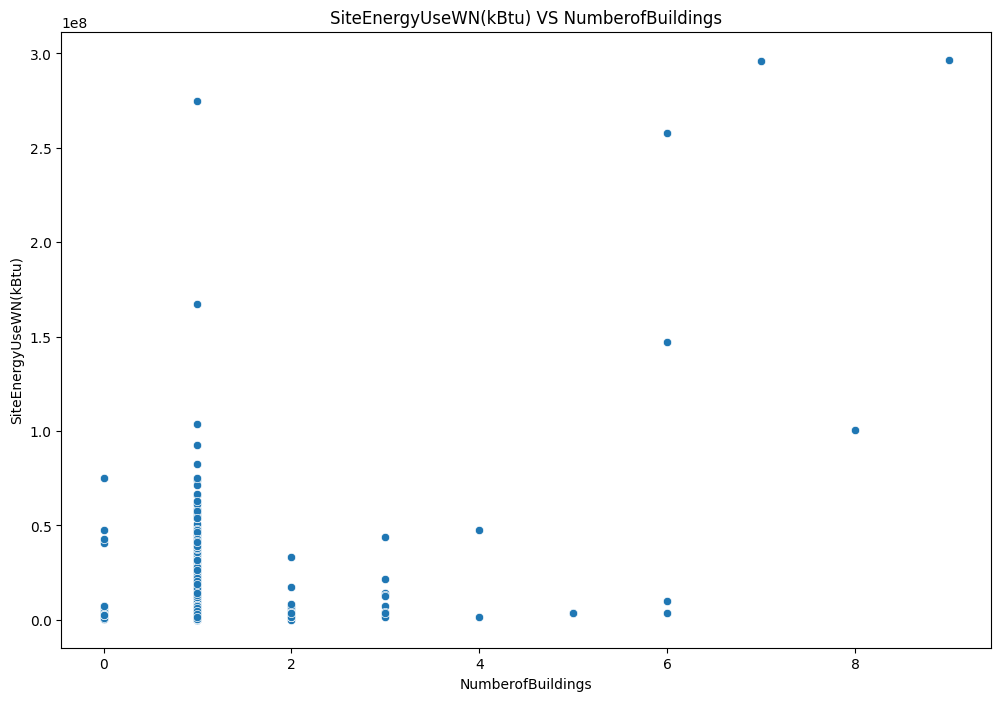

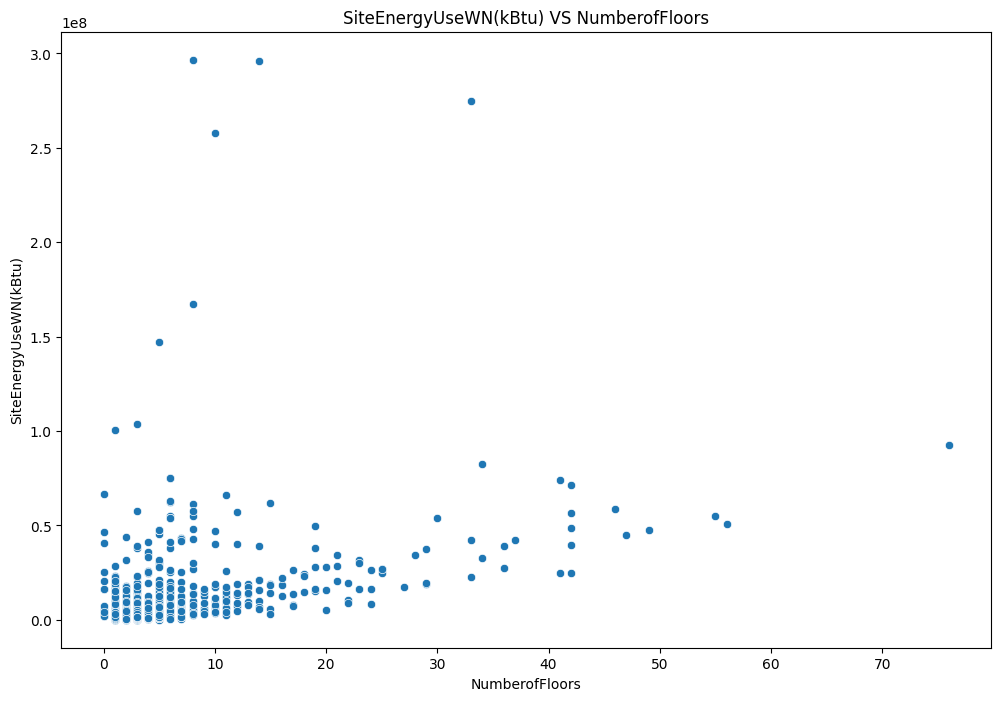

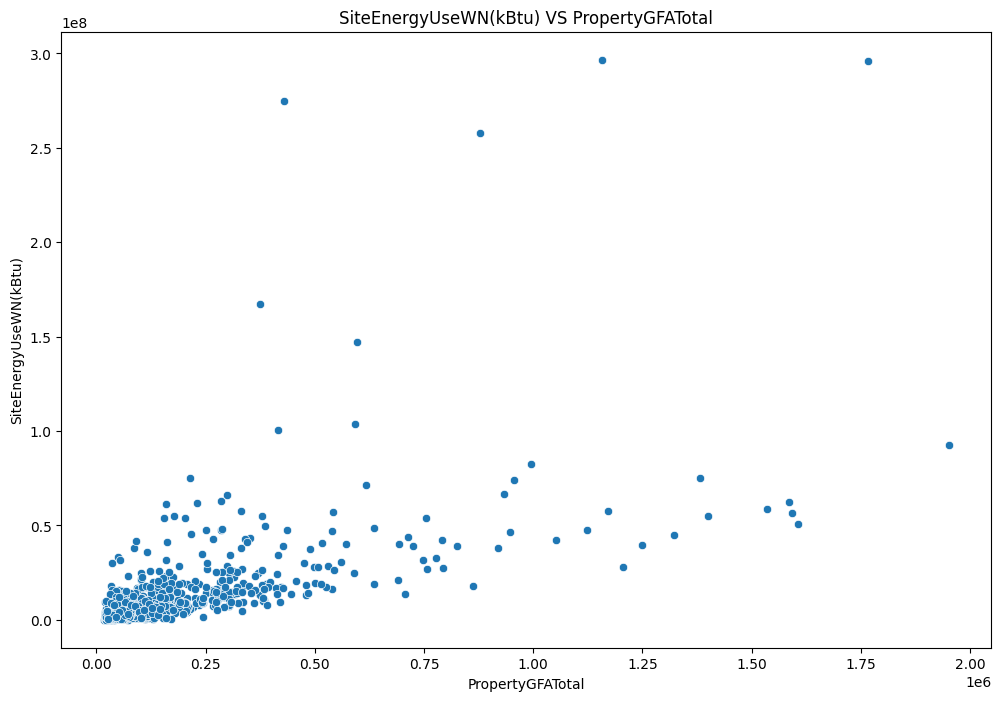

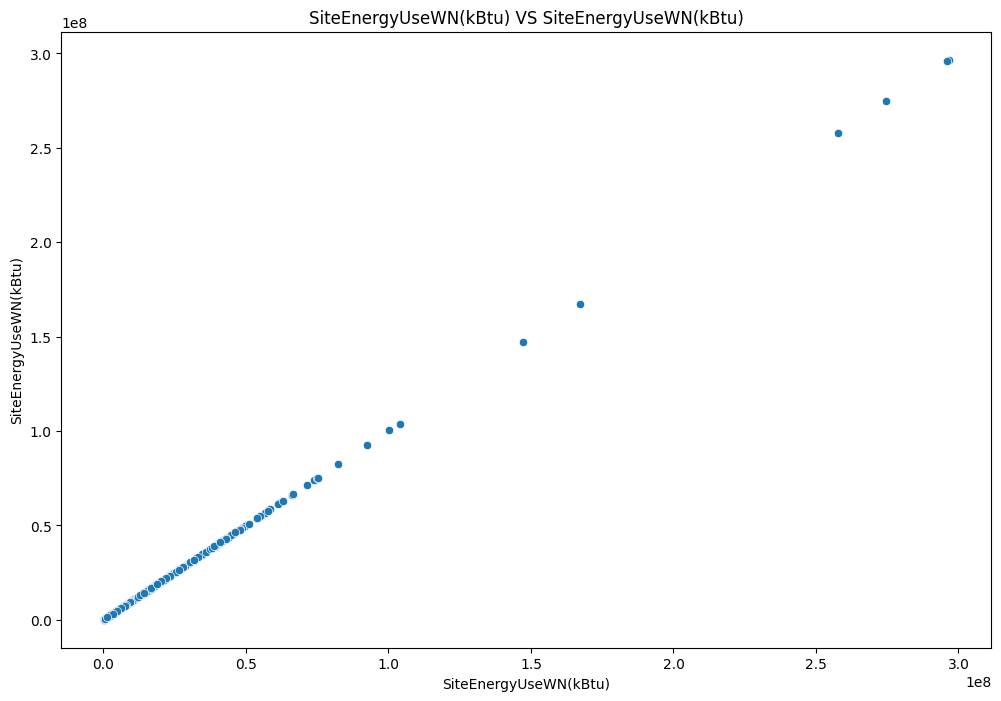

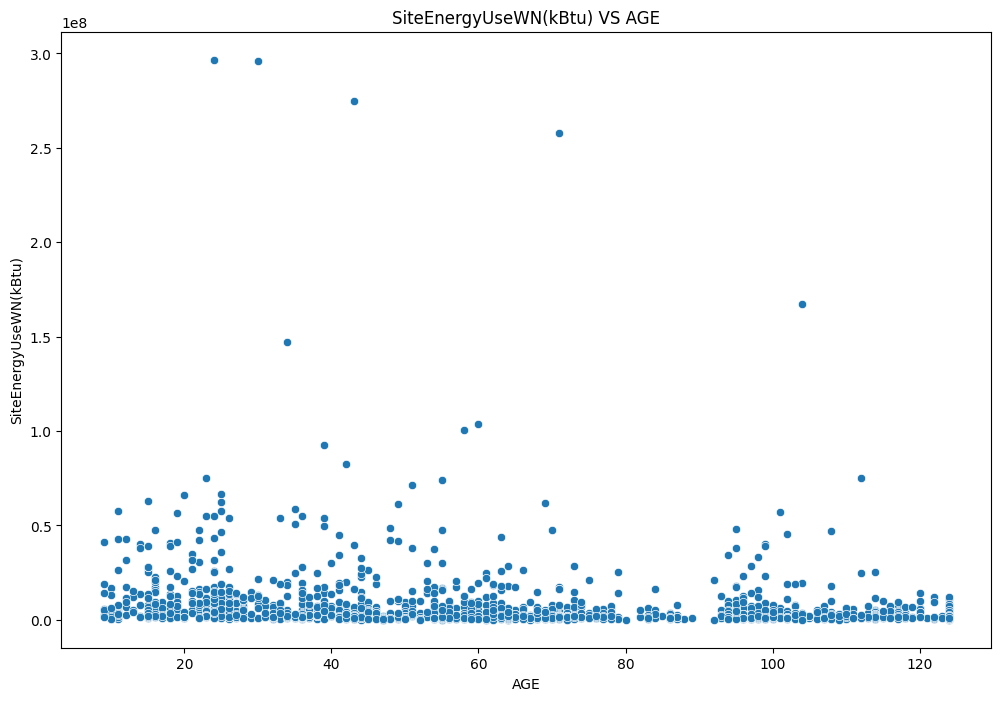

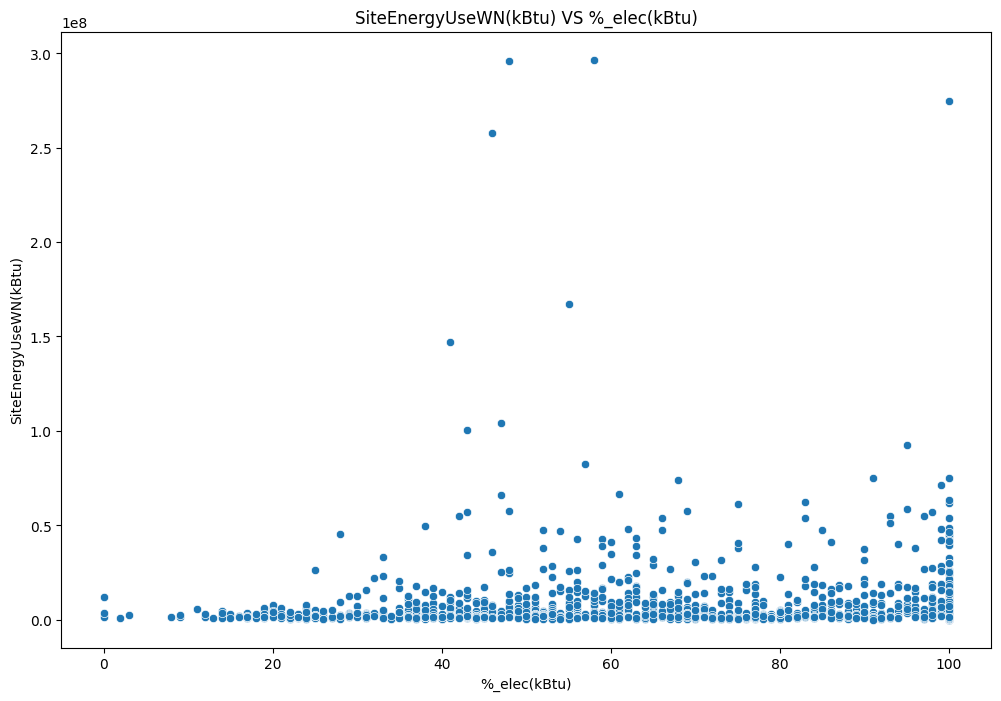

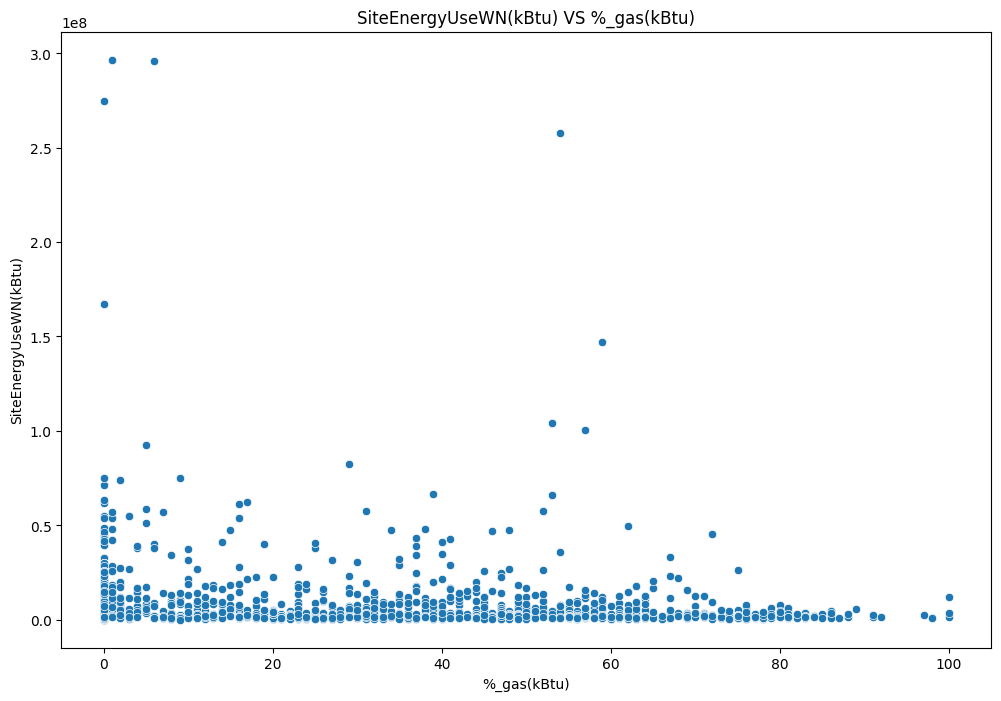

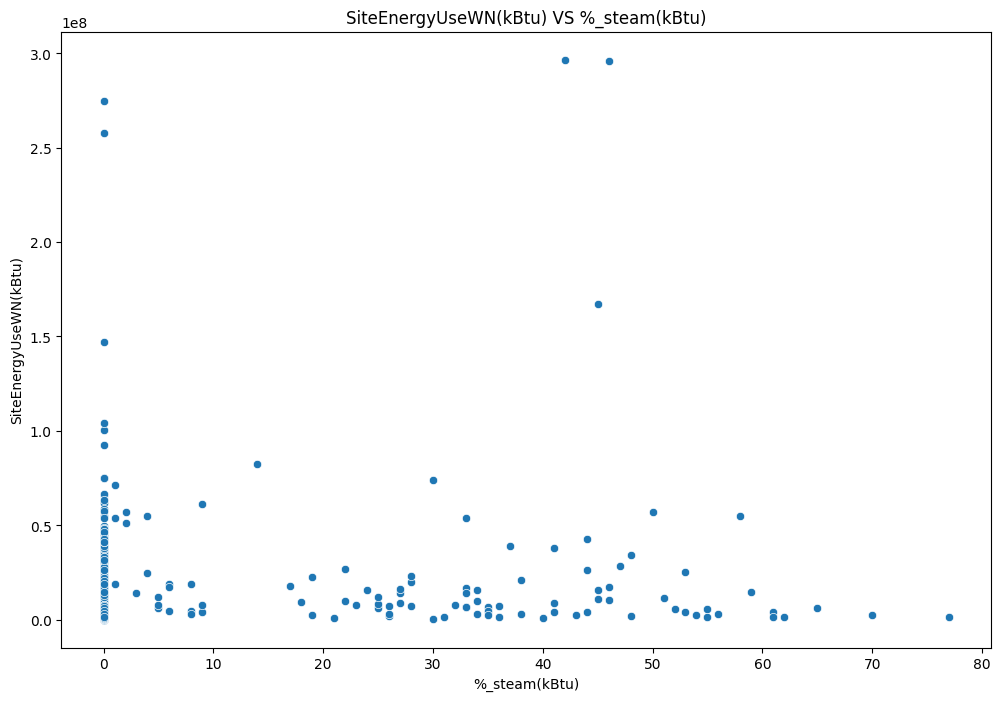

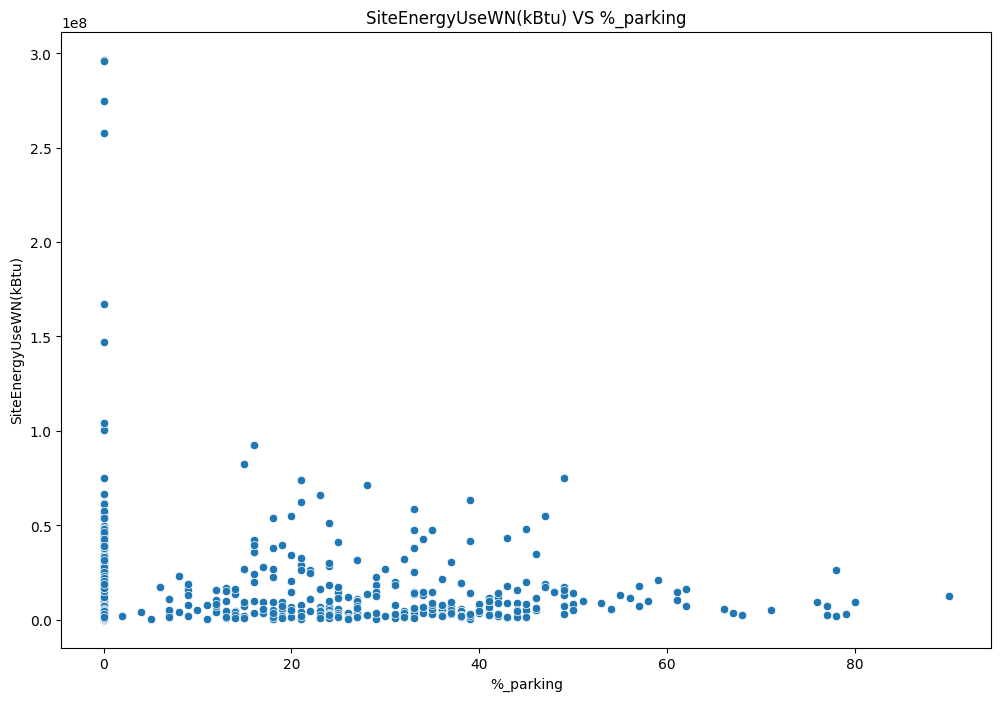

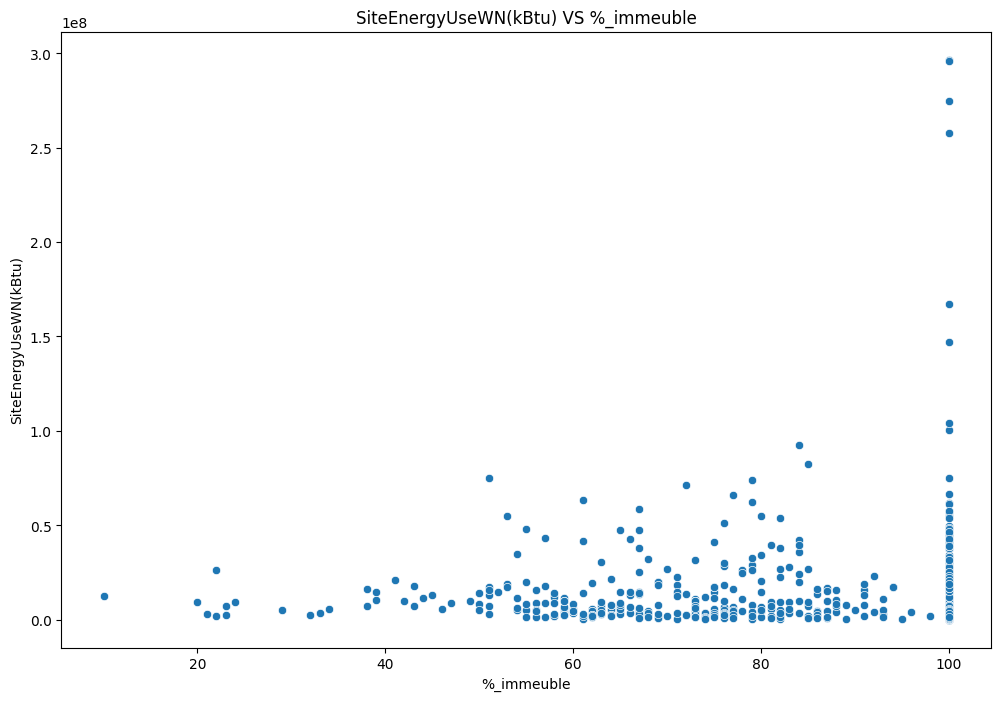

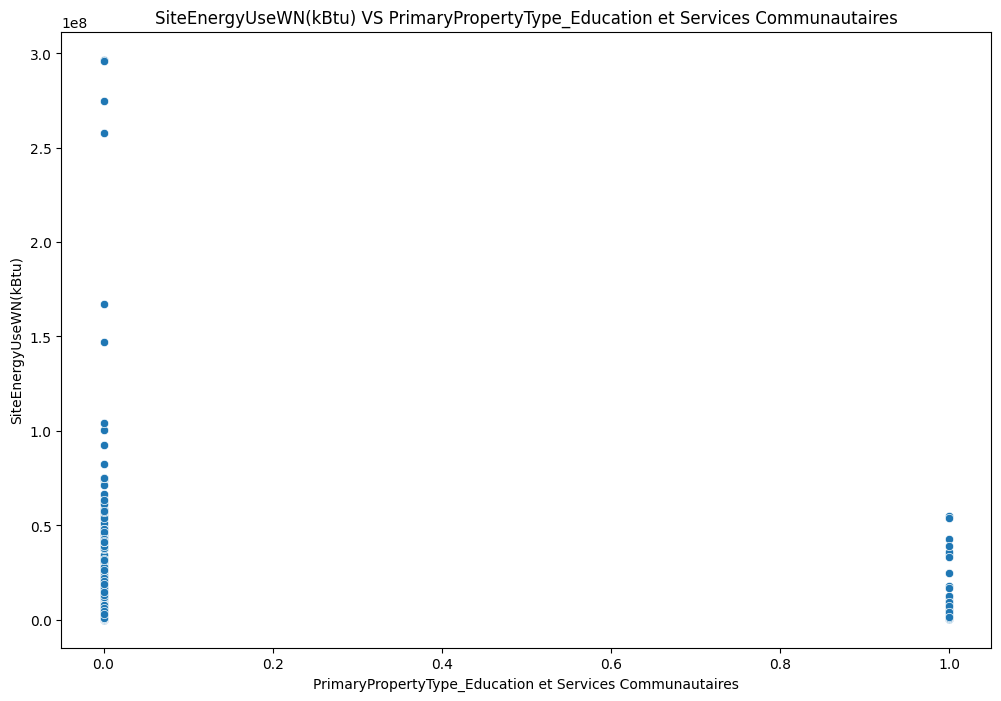

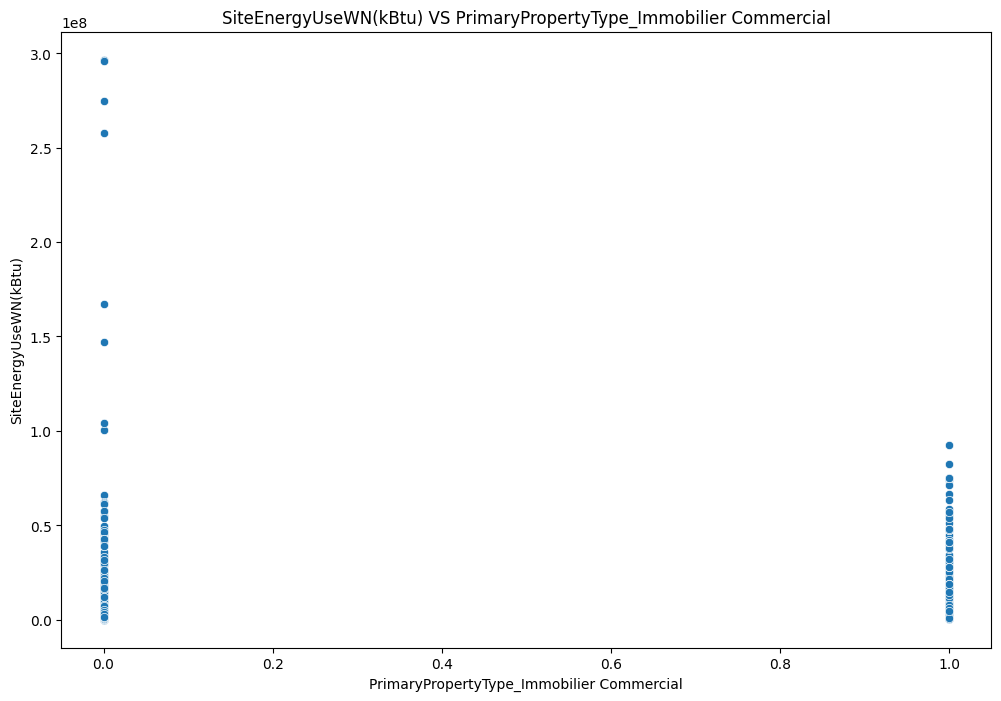

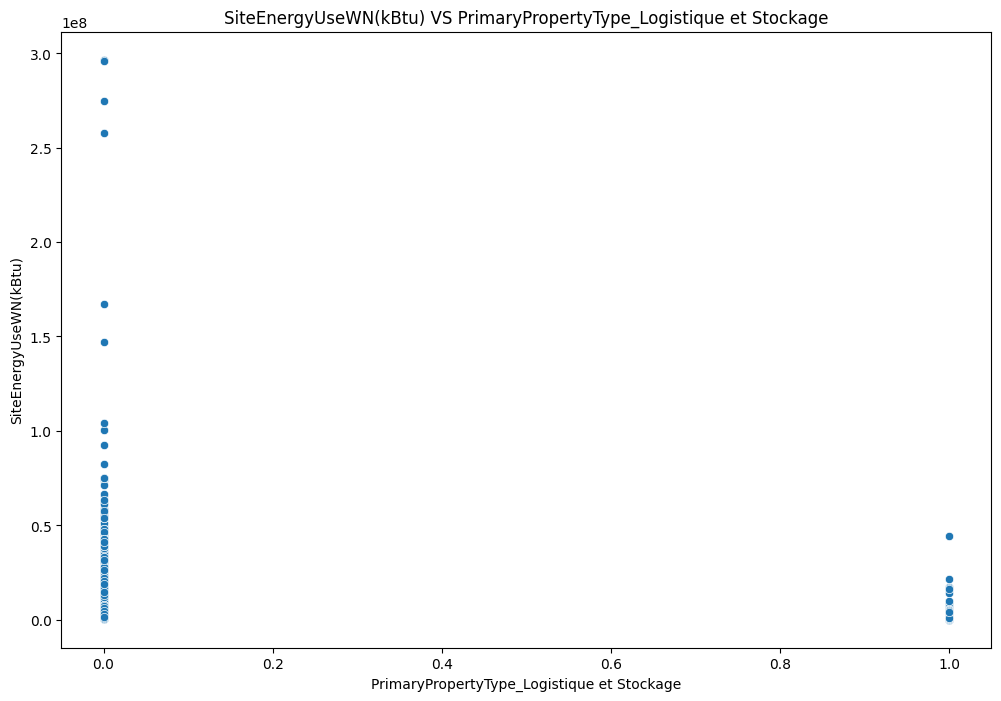

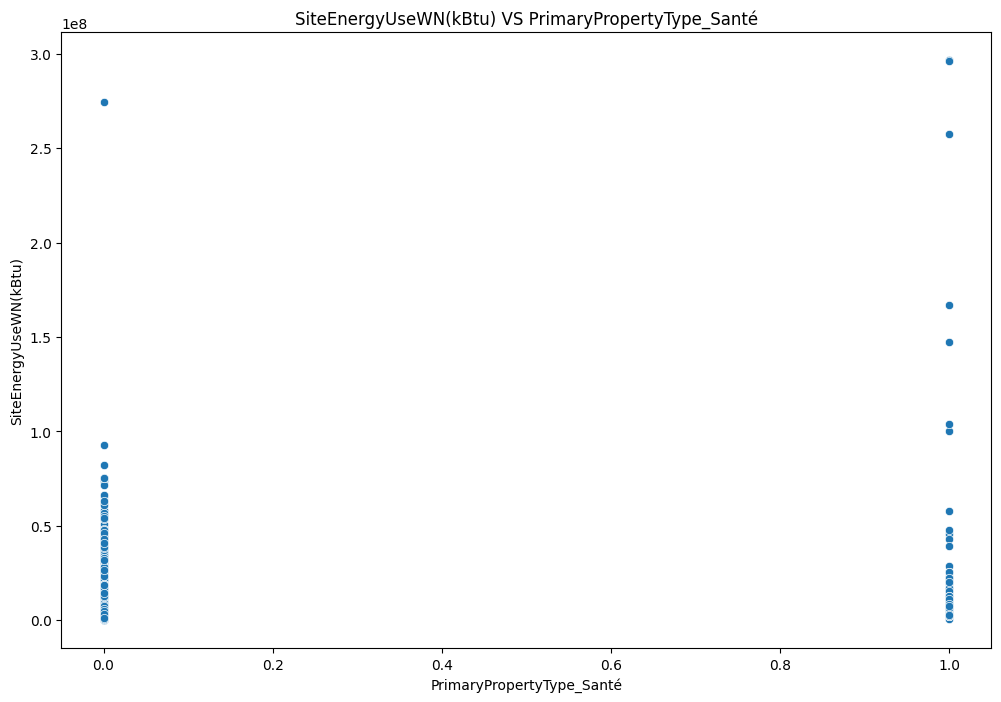

In [3477]:
for col in col_num:
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=DF_cleaned_lineaire[col],y=DF_cleaned_lineaire[TARGET])
    plt.title(f'{TARGET} VS {col}')
    plt.show()

## ANALYSE STATS MODELS

In [3478]:
X=DF_cleaned_lineaire[col_num].drop([TARGET],axis=1)
y=DF_cleaned_lineaire[TARGET]


X=sm.add_constant(X)

In [3479]:
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.585
Model:                               OLS   Adj. R-squared:                  0.581
Method:                    Least Squares   F-statistic:                     124.5
Date:                   Mon, 11 Nov 2024   Prob (F-statistic):          5.79e-256
Time:                           21:45:58   Log-Likelihood:                -25381.
No. Observations:                   1429   AIC:                         5.080e+04
Df Residuals:                       1412   BIC:                         5.088e+04
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

## SELECTION VARIABLES

1. Analyse des corrélations

Corrélations avec SiteEnergyUse:
SiteEnergyUseWN(kBtu)                                       1.000000
PropertyGFATotal                                            0.652583
NumberofBuildings                                           0.465448
NumberofFloors                                              0.418355
PrimaryPropertyType_Santé                                   0.268065
%_steam(kBtu)                                               0.193147
CouncilDistrictCode                                         0.101477
%_parking                                                   0.097619
Longitude                                                   0.036487
Latitude                                                    0.018691
PrimaryPropertyType_Immobilier Commercial                   0.017369
%_elec(kBtu)                                                0.004742
ZipCode                                                    -0.051116
PrimaryPropertyType_Education et Services

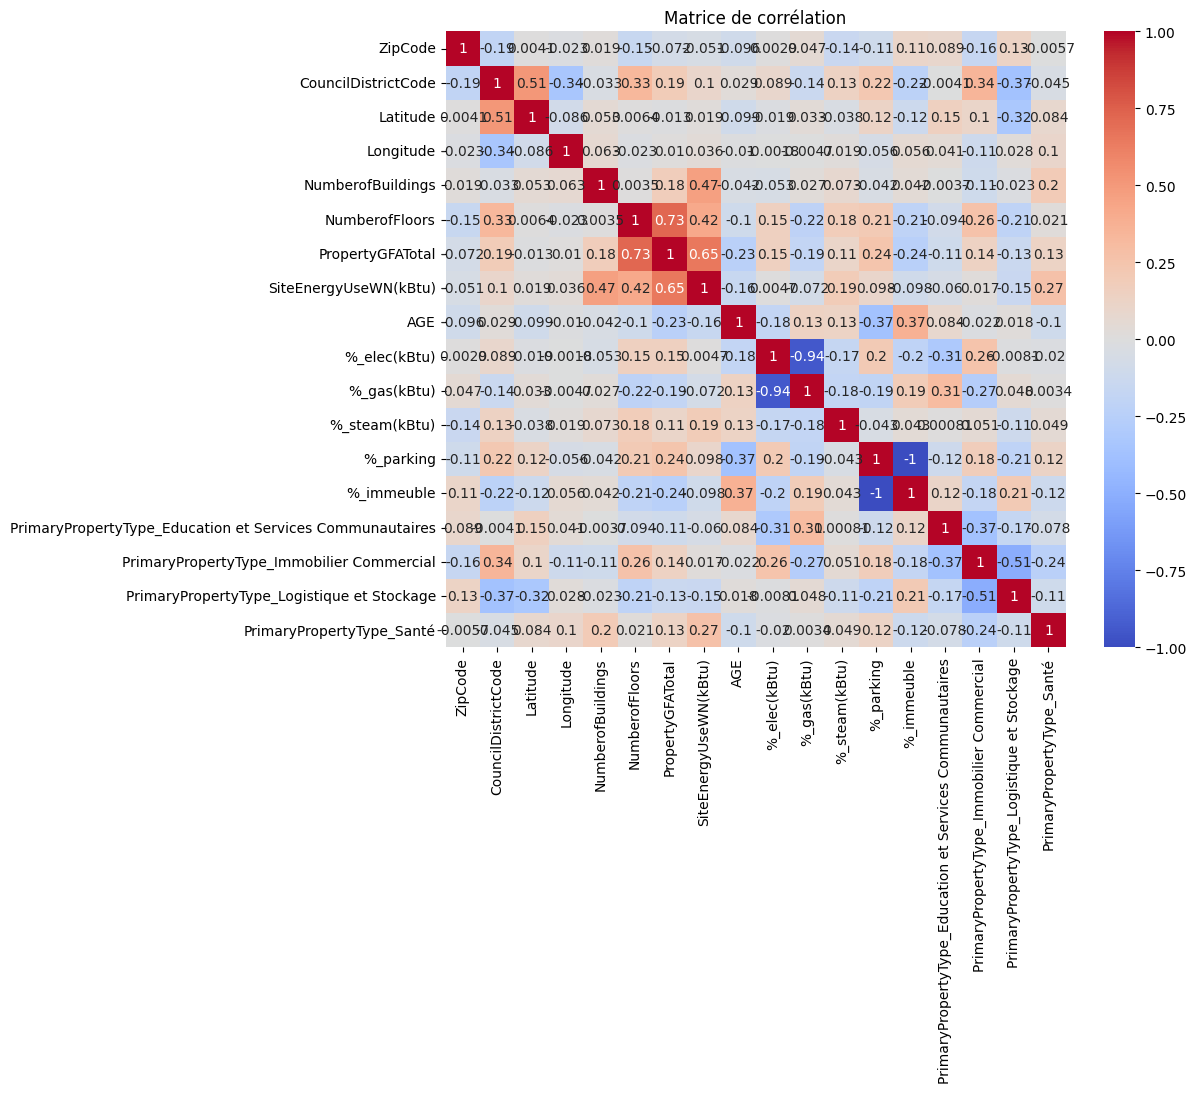

In [3480]:

from scipy import stats



data=DF_cleaned_lineaire[col_num]


# 1. Analyse des corrélations
print("1. Analyse des corrélations")
correlations = data[col_num].corr()[TARGET].sort_values(ascending=False)
print("\nCorrélations avec SiteEnergyUse:")
print(correlations)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(data[col_num].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation')
plt.show()


In [3481]:

# 2. Test de significativité individuelle
print("\n2. Tests de significativité individuelle")
X = sm.add_constant(data.drop([TARGET],axis=1))
model = sm.OLS(data[TARGET], X).fit()
print("\nRésumé des p-values:")
p_values = pd.DataFrame({
    'Variable': X.columns,
    'P-value': model.pvalues,
    'Significatif': model.pvalues < 0.05
}).sort_values('P-value')
print(p_values)



2. Tests de significativité individuelle

Résumé des p-values:
                                                                                             Variable  \
PropertyGFATotal                                                                     PropertyGFATotal   
NumberofBuildings                                                                   NumberofBuildings   
PrimaryPropertyType_Santé                                                   PrimaryPropertyType_Santé   
PrimaryPropertyType_Logistique et Stockage                 PrimaryPropertyType_Logistique et Stockage   
AGE                                                                                               AGE   
%_steam(kBtu)                                                                           %_steam(kBtu)   
%_gas(kBtu)                                                                               %_gas(kBtu)   
%_elec(kBtu)                                                                             %_elec(

In [3482]:

# 3. Analyse VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

print("\n3. Analyse VIF (multicolinéarité)")
vif_data = calculate_vif(X.drop('const', axis=1))
print(vif_data)



3. Analyse VIF (multicolinéarité)
                                             Variable           VIF
12                                         %_immeuble  5.411593e+07
11                                          %_parking  1.582577e+06
9                                         %_gas(kBtu)  5.370570e+04
8                                        %_elec(kBtu)  5.353577e+04
10                                      %_steam(kBtu)  6.630892e+03
14          PrimaryPropertyType_Immobilier Commercial  2.604243e+00
5                                      NumberofFloors  2.550359e+00
6                                    PropertyGFATotal  2.469027e+00
15         PrimaryPropertyType_Logistique et Stockage  2.213080e+00
1                                 CouncilDistrictCode  2.150007e+00
13  PrimaryPropertyType_Education et Services Comm...  1.746067e+00
2                                            Latitude  1.625563e+00
16                          PrimaryPropertyType_Santé  1.376235e+00
7            

In [3483]:

# 4. Analyse des R² ajustés avec différentes combinaisons
def evaluate_feature_importance(data):
    results = []
    base_features = []
    remaining_features = list(data.drop(TARGET, axis=1).columns)
    
    while remaining_features:
        best_score = -np.inf
        best_feature = None
        
        for feature in remaining_features:
            current_features = base_features + [feature]
            X = sm.add_constant(data[current_features])
            model = sm.OLS(data[TARGET], X).fit()
            score = model.rsquared_adj
            
            results.append({
                'features': ', '.join(current_features),
                'feature_added': feature,
                'r2_adj': score
            })
            
            if score > best_score:
                best_score = score
                best_feature = feature
        
        if best_feature:
            base_features.append(best_feature)
            remaining_features.remove(best_feature)
            
    return pd.DataFrame(results)

print("\n4. Analyse progressive des caractéristiques")
feature_importance = evaluate_feature_importance(data=data)
print(feature_importance.sort_values('r2_adj', ascending=False).head())



4. Analyse progressive des caractéristiques
                                              features  \
142  PropertyGFATotal, NumberofBuildings, PrimaryPr...   
121  PropertyGFATotal, NumberofBuildings, PrimaryPr...   
129  PropertyGFATotal, NumberofBuildings, PrimaryPr...   
130  PropertyGFATotal, NumberofBuildings, PrimaryPr...   
136  PropertyGFATotal, NumberofBuildings, PrimaryPr...   

                                         feature_added    r2_adj  
142          PrimaryPropertyType_Immobilier Commercial  0.581561  
121                                     NumberofFloors  0.581486  
129                                         %_immeuble  0.581486  
130  PrimaryPropertyType_Education et Services Comm...  0.581430  
136  PrimaryPropertyType_Education et Services Comm...  0.581430  


In [3484]:

# 5. Sélection finale des variables
def select_significant_variables(data, threshold_p_value=0.05, threshold_vif=125):
    # Première étape : sélection basée sur p-value
    X = sm.add_constant(data.drop([TARGET],axis=1))
    model = sm.OLS(data[TARGET], X).fit()
    significant_vars = X.columns[model.pvalues < threshold_p_value].tolist()
    
    
    
    # Deuxième étape : vérification VIF
    selected_vars = []
    X_significant = data[significant_vars]
    vif_data = calculate_vif(X_significant)
    
    for var in significant_vars:
        if vif_data[vif_data['Variable'] == var]['VIF'].values[0] < threshold_vif:
            selected_vars.append(var)
    #selected_vars.remove('const')
    return selected_vars

print("\n5. Sélection finale des variables")
selected_vars = select_significant_variables(data)
print("\nVariables sélectionnées:")
print(selected_vars)



5. Sélection finale des variables

Variables sélectionnées:
['NumberofBuildings', 'PropertyGFATotal', 'PrimaryPropertyType_Logistique et Stockage', 'PrimaryPropertyType_Santé']


In [3485]:

# Modèle final avec les variables sélectionnées
X_final = sm.add_constant(data[selected_vars])
final_model = sm.OLS(data[TARGET], X_final).fit()
print("\nRésumé du modèle final:")
print(final_model.summary())


Résumé du modèle final:
                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.570
Model:                               OLS   Adj. R-squared:                  0.568
Method:                    Least Squares   F-statistic:                     471.1
Date:                   Mon, 11 Nov 2024   Prob (F-statistic):          8.71e-259
Time:                           21:45:59   Log-Likelihood:                -25407.
No. Observations:                   1429   AIC:                         5.082e+04
Df Residuals:                       1424   BIC:                         5.085e+04
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [3486]:
col_num_sel_lin=selected_vars
print(col_num_sel_lin)

['NumberofBuildings', 'PropertyGFATotal', 'PrimaryPropertyType_Logistique et Stockage', 'PrimaryPropertyType_Santé']


### vERIFICATION DES CORRELATIONS

In [3487]:
def check_correlations(data, threshold=0.95):
    corr_matrix = data.corr().abs()
    high_corr = np.where(abs(corr_matrix) > threshold)
    pairs = [(data.columns[i], data.columns[j], corr_matrix.iloc[i,j]) 
             for i, j in zip(*high_corr) if i < j]
    if pairs:
        print("Attention : Fortes corrélations détectées")
        for var1, var2, corr in pairs:
            print(f"{var1} - {var2}: {corr:.3f}")
    return pairs

print('Voilà les features qui semblent corrélées entre elles :')
check_correlations(DF_cleaned_lineaire[col_num_sel_lin])

Voilà les features qui semblent corrélées entre elles :


[]

# 'SiteEnergyUse(kBtu)'

### DUMMY

In [3488]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X=DF_cleaned_lineaire[col_num_sel_lin]
y=DF_cleaned_lineaire[TARGET]

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un Dummy Regressor qui prédit la moyenne
dummy_reg = DummyRegressor(strategy="mean")

# Entraîner le modèle
dummy_reg.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_dummy = dummy_reg.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred_dummy)

print(f"Mean Squared Error: {mse}")

# Calculer la racine de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculer le coefficient de détermination R²
r2 = r2_score(y_test, y_pred_dummy)
print(f"R² Score: {r2}")


Mean Squared Error: 103167125890943.47
Root Mean Squared Error: 10157121.929510519
R² Score: -0.05520967428754209


### REGRESSION LINEAIRE AVEC SEULEMENT LES VARIABLES IMPORTANTES

In [3489]:

X_test,y_test,y_pred_linear,y_pred_linear_train,y_pred_linear_general,mse_normale,r2_normal,\
    mape_normal,mae_normal,rlin=\
reg_lin(DF_cleaned_lineaire,col_num_sel_lin,TARGET,'RAS','None')

Linear Regression R² Score test: 0.53
Linear Regression MSE test: 4.57e+13
Linear Regression MAE test: 3.81e+06
Linear Regression MAPE test: 123.27 %
Linear Regression R² Score train: 0.57
Linear Regression MSE train: 1.92e+14
Linear Regression MAE train: 5.37e+06
Linear Regression MAPE train: 134.39 %
Linear Regression R² Score general: 0.57
Linear Regression MSE general: 1.63e+14
Linear Regression MAE general: 5.05e+06
Linear Regression MAPE general: 132.17 %


### REPRESENTATION

Représentation des prédictions linéaires et des prédictions dummy


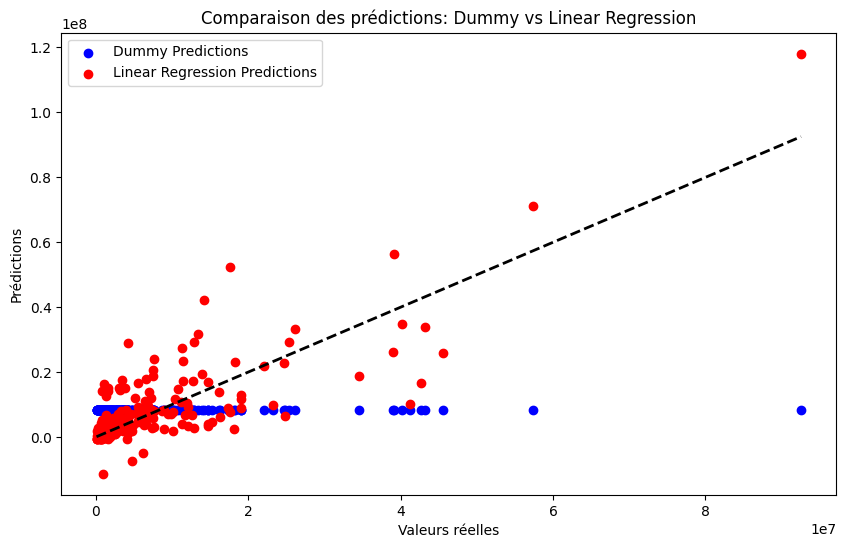

In [3490]:
representation_predictions(y_test,y_pred_dummy,y_pred_linear)

# ON CONTINUE LA VERIFICATION DES HYPOTHESES DE LA REGRESSION LINEAIRE


0) Plot des résidus vs valeurs prédites


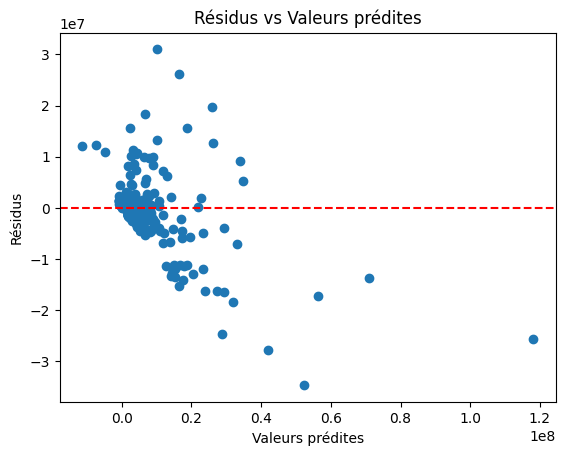


1) Indépendance des résidus (Test de Durbin-Watson)
Durbin-Watson test: 1.8399420932806674
Plutot bon

2) Etude de l'homoscedasticité
Statistiques du test de Breusch-Pagan:
p-value : 0.0000
statistique de test : 114.2789
Il y a de l'hétéroscédasticité (rejet de H0)

3) QQ-plot


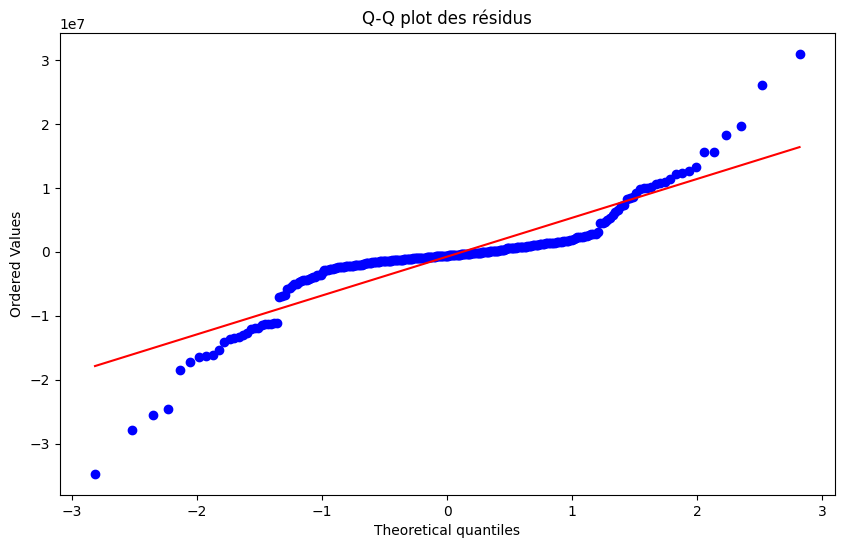

p-value du test Shapiro-Wilk : 7.191837847689103e-18
résidus non normaux

4) Etude des valeurs aberrantes (Distance de Cook)


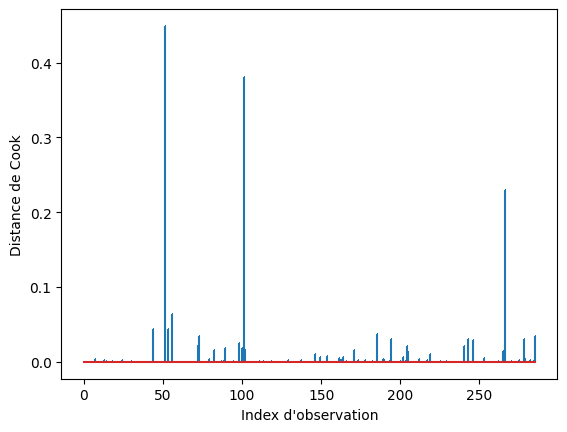

In [3491]:
suite_hypothéses(X_test,y_test,y_pred_linear)

# ON VA MAINTENANT LOG LA VARIABLE CIBLE

In [3492]:
X_test,y_test,y_pred_linear,y_pred_linear_train,y_pred_linear_general,mse_log_target,r2_log_target,\
    mape_log_target,mae_log_target,rlin=\
reg_lin(DF_cleaned_lineaire,col_num_sel_lin,TARGET,'log_target','None')

Linear Regression R² Score test: -562.47
Linear Regression MSE test: 5.51e+16
Linear Regression MAE test: 1.79e+07
Linear Regression MAPE test: 116.33 %
Linear Regression R² Score train: -62.21
Linear Regression MSE train: 2.82e+16
Linear Regression MAE train: 1.42e+07
Linear Regression MAPE train: 104.53 %
Linear Regression R² Score general: -88.00
Linear Regression MSE general: 3.36e+16
Linear Regression MAE general: 1.50e+07
Linear Regression MAPE general: 106.89 %


Représentation des prédictions linéaires et des prédictions dummy


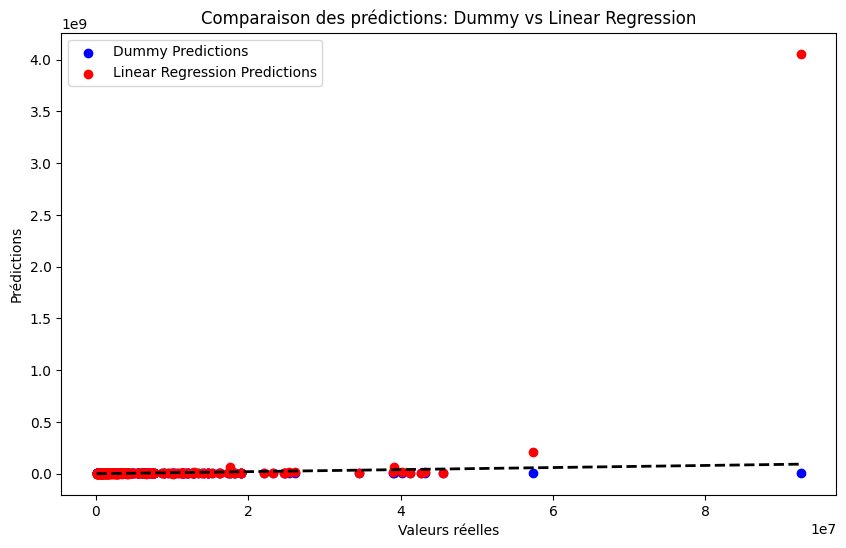

In [3493]:
representation_predictions(y_test,y_pred_dummy,y_pred_linear)

LES RESULTATS SONT TRES MAUVAIS AVEC CETTE APPROCHE

# ON VA MAINTENANT LOG LA VARIABLE PropertyGFATotal EN PLUS DE LA CIBLE


In [3494]:
X_test,y_test,y_pred_linear,y_pred_linear_train,y_pred_linear_general,mse_log_target_feature,\
    r2_log_target_feature,mape_log_target_feature,mae_log_target_feature,reglin=\
reg_lin(DF_cleaned_lineaire,col_num_sel_lin,TARGET,'log_target_feature','PropertyGFATotal')

Linear Regression R² Score test: 0.69
Linear Regression MSE test: 2.99e+13
Linear Regression MAE test: 2.74e+06
Linear Regression MAPE test: 67.01 %
Linear Regression R² Score train: 0.67
Linear Regression MSE train: 1.46e+14
Linear Regression MAE train: 4.00e+06
Linear Regression MAPE train: 69.42 %
Linear Regression R² Score general: 0.67
Linear Regression MSE general: 1.23e+14
Linear Regression MAE general: 3.75e+06
Linear Regression MAPE general: 68.94 %


Représentation des prédictions linéaires et des prédictions dummy


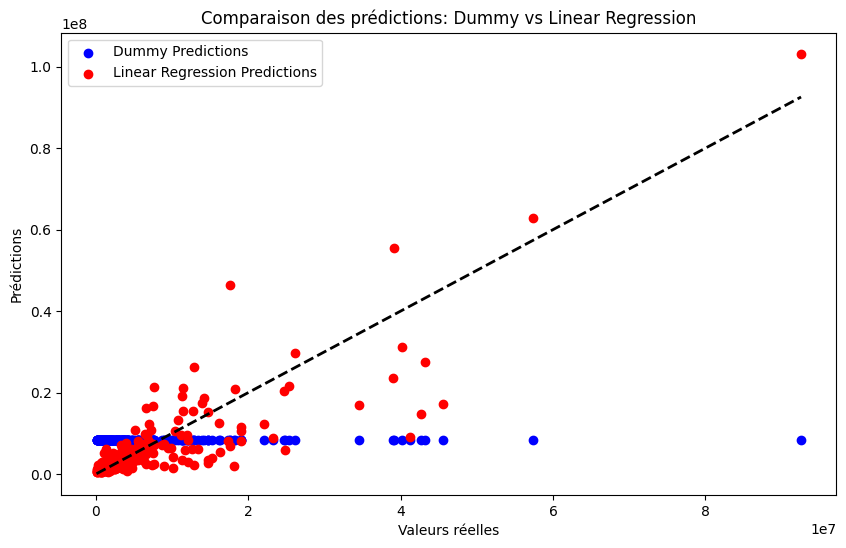

In [3495]:
representation_predictions(y_test,y_pred_dummy,y_pred_linear)

0) Plot des résidus vs valeurs prédites


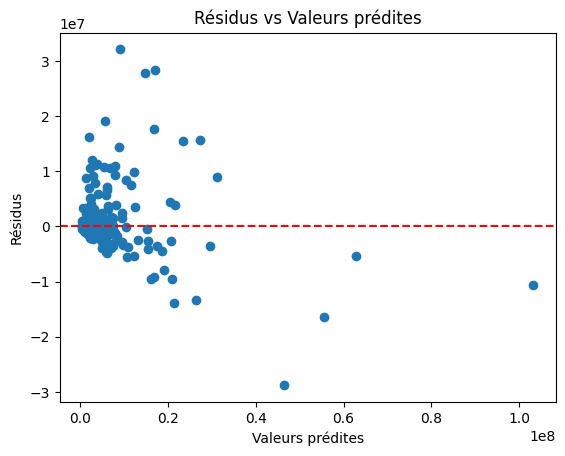


1) Indépendance des résidus (Test de Durbin-Watson)
Durbin-Watson test: 1.7113764239436344
Plutot bon

2) Etude de l'homoscedasticité
Statistiques du test de Breusch-Pagan:
p-value : 0.0000
statistique de test : 45.1080
Il y a de l'hétéroscédasticité (rejet de H0)

3) QQ-plot


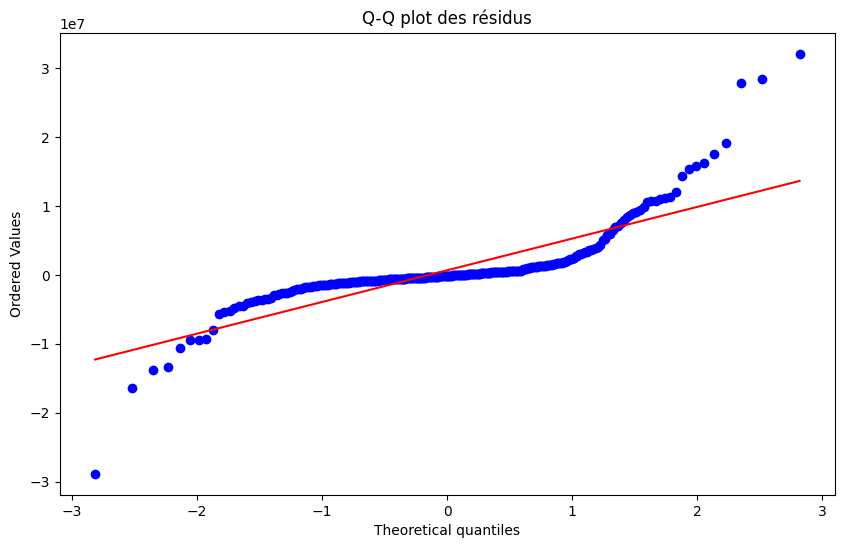

p-value du test Shapiro-Wilk : 9.814870955940638e-22
résidus non normaux

4) Etude des valeurs aberrantes (Distance de Cook)


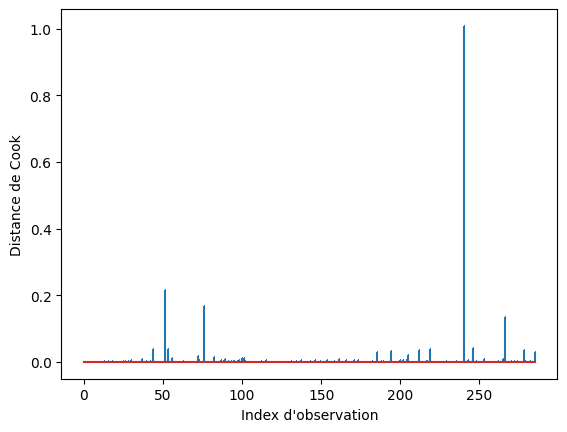

In [3496]:
suite_hypothéses(X_test,y_test,y_pred_linear)

In [3497]:
nouvelle_ligne=r2_log_target_feature.to_frame().T
nouvelle_ligne.index=['Reg_lin']

Tableau_score_r2=pd.concat([Tableau_score_r2,nouvelle_ligne])

nouvelle_ligne=mae_log_target_feature.to_frame().T
nouvelle_ligne.index=['Reg_lin']

Tableau_score_mae=pd.concat([Tableau_score_mae,nouvelle_ligne])

nouvelle_ligne=mape_log_target_feature.to_frame().T
nouvelle_ligne.index=['Reg_lin']

Tableau_score_mape=pd.concat([Tableau_score_mape,nouvelle_ligne])

nouvelle_ligne=mse_log_target_feature.to_frame().T
nouvelle_ligne.index=['Reg_lin']

Tableau_score_mse=pd.concat([Tableau_score_mse,nouvelle_ligne])

nouvelle_ligne=pd.Series([len(col_num_sel_lin)],index=['Nbre Feature Pertinentes']).to_frame().T
nouvelle_ligne.index=['Reg_lin']

Tableau_score_feature=pd.concat([Tableau_score_feature,nouvelle_ligne])


# REGRESSION REGULARISEE

In [3498]:
col_num=list(DF_cleaned_lineaire[col_num].columns)

del(col_num[col_num.index(TARGET)])
print(col_num)

['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'AGE', '%_elec(kBtu)', '%_gas(kBtu)', '%_steam(kBtu)', '%_parking', '%_immeuble', 'PrimaryPropertyType_Education et Services Communautaires', 'PrimaryPropertyType_Immobilier Commercial', 'PrimaryPropertyType_Logistique et Stockage', 'PrimaryPropertyType_Santé']


## REGRESSION AVEC TOUTES LES FEATURES

In [3499]:
ridge,lasso,elastic,resultats,y_test,y_pred_elastic,scl=reg_regul(DF_cleaned_lineaire,col_num,
                                                              TARGET,type='RAS',log_feature=['None'])


Comparaison des coefficients:
                                                           Ridge  \
PropertyGFATotal                                    1.237933e+07   
NumberofBuildings                                   6.907847e+06   
PrimaryPropertyType_Santé                           2.321474e+06   
%_steam(kBtu)                                       2.386563e+06   
PrimaryPropertyType_Logistique et Stockage         -1.725943e+06   
NumberofFloors                                     -8.774171e+05   
AGE                                                -7.910972e+05   
PrimaryPropertyType_Immobilier Commercial          -8.958164e+05   
%_parking                                          -6.353474e+05   
PrimaryPropertyType_Education et Services Commu... -6.005872e+05   
%_gas(kBtu)                                         6.796664e+05   
Latitude                                           -4.107928e+05   
%_elec(kBtu)                                       -1.045858e+05   
%_immeuble       

<Figure size 1200x600 with 0 Axes>

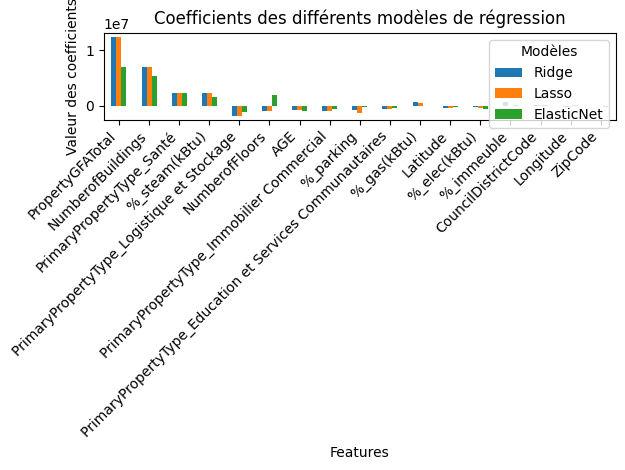


Variables sélectionnées par Lasso (coefficients non nuls):
                                              Feature   Coefficient
6                                    PropertyGFATotal  1.240428e+07
4                                   NumberofBuildings  6.909171e+06
16                          PrimaryPropertyType_Santé  2.319805e+06
10                                      %_steam(kBtu)  2.315696e+06
15         PrimaryPropertyType_Logistique et Stockage -1.729411e+06
11                                          %_parking -1.273063e+06
14          PrimaryPropertyType_Immobilier Commercial -8.975383e+05
5                                      NumberofFloors -8.967024e+05
7                                                 AGE -7.896102e+05
13  PrimaryPropertyType_Education et Services Comm... -6.019693e+05
9                                         %_gas(kBtu)  4.639179e+05
2                                            Latitude -4.118577e+05
8                                        %_elec(kBtu) -3

In [3500]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X=DF_cleaned_lineaire[col_num]

# Création d'un DataFrame pour comparer les coefficients des différents modèles
def compare_coefficients(models, model_names, feature_names):
    coefficients = pd.DataFrame()
    for model, name in zip(models, model_names):
        coefficients[name] = model.coef_
    coefficients.index = feature_names
    
    # Trier par valeur absolue des coefficients (moyenne des 3 modèles)
    coefficients['Moyenne_Abs'] = coefficients.abs().mean(axis=1)
    coefficients = coefficients.sort_values('Moyenne_Abs', ascending=False)
    
    print("\nComparaison des coefficients:")
    print(coefficients)
    
    # Visualisation
    plt.figure(figsize=(12, 6))
    coefficients[model_names].plot(kind='bar')
    plt.title('Coefficients des différents modèles de régression')
    plt.xlabel('Features')
    plt.ylabel('Valeur des coefficients')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Modèles')
    plt.tight_layout()
    plt.show()
    
    return coefficients

# Utilisation de la fonction
models = [ridge, lasso, elastic]
model_names = ['Ridge', 'Lasso', 'ElasticNet']
coef_comparison = compare_coefficients(models, model_names, X.columns)

# Analyse spécifique pour Lasso (sélection de variables)
print("\nVariables sélectionnées par Lasso (coefficients non nuls):")
lasso_selected = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})
lasso_selected = lasso_selected[lasso_selected['Coefficient'] != 0]
lasso_selected = lasso_selected.sort_values('Coefficient', key=abs, ascending=False)
print(lasso_selected)


Features importantes (importance > 0.01):
                                                       Ridge         Lasso  \
PropertyGFATotal                                    1.000000  1.000000e+00   
NumberofBuildings                                   0.558015  5.569991e-01   
PrimaryPropertyType_Santé                           0.187528  1.870166e-01   
%_steam(kBtu)                                       0.192786  1.866853e-01   
NumberofFloors                                      0.070878  7.228977e-02   
PrimaryPropertyType_Logistique et Stockage          0.139421  1.394205e-01   
AGE                                                 0.063905  6.365628e-02   
PrimaryPropertyType_Immobilier Commercial           0.072364  7.235716e-02   
%_parking                                           0.051323  1.026309e-01   
PrimaryPropertyType_Education et Services Commu...  0.048515  4.852917e-02   
%_elec(kBtu)                                        0.008448  2.591945e-02   
%_gas(kBtu)          

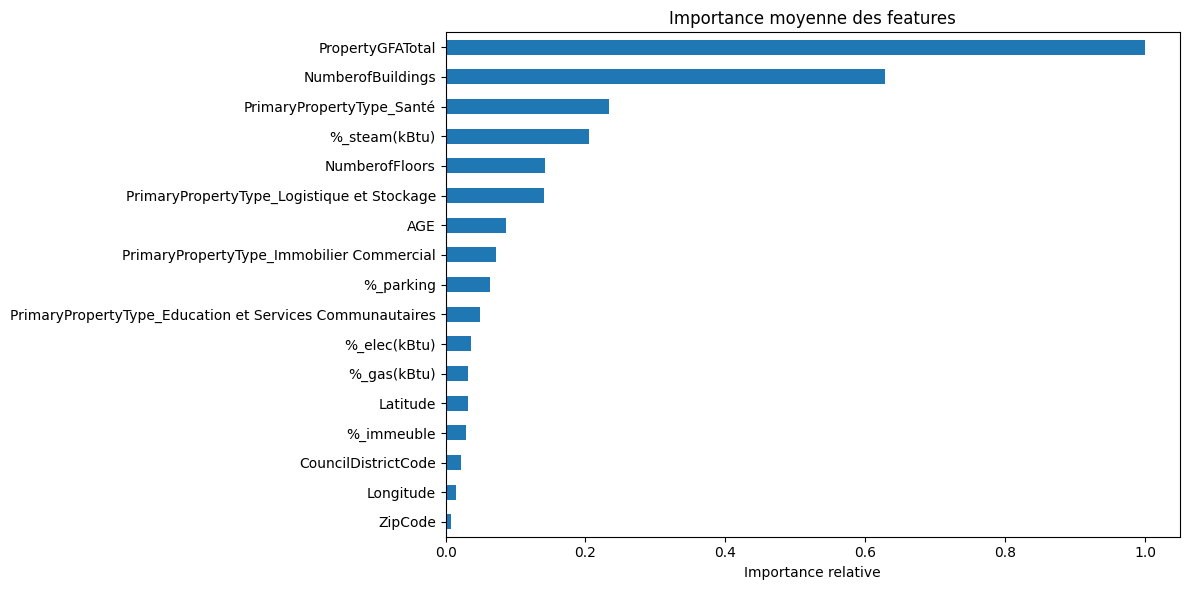

In [3501]:
def analyze_feature_importance(models, model_names, feature_names, threshold=0.01):
    importance_summary = pd.DataFrame()
    
    for model, name in zip(models, model_names):
        # Normaliser les coefficients
        normalized_coef = np.abs(model.coef_) / np.abs(model.coef_).max()
        importance_summary[name] = normalized_coef
    
    importance_summary.index = feature_names
    
    # Calculer le score moyen d'importance
    importance_summary['Importance_moyenne'] = importance_summary.mean(axis=1)
    
    # Identifier les features importantes
    important_features = importance_summary[
        importance_summary['Importance_moyenne'] > threshold
    ].sort_values('Importance_moyenne', ascending=False)
    
    print("\nFeatures importantes (importance > {}):".format(threshold))
    print(important_features)
    col_num_sel=list(important_features.head(6).index)
    # Visualisation
    plt.figure(figsize=(12, 6))
    importance_summary['Importance_moyenne'].sort_values().plot(kind='barh')
    plt.title('Importance moyenne des features')
    plt.xlabel('Importance relative')
    plt.tight_layout()
    plt.show()
    
    return importance_summary,list(col_num_sel)

# Utilisation de la fonction
importance_analysis,col_num_sel_regu = analyze_feature_importance(models, model_names, X.columns)

## REGRESSION REGULARISEE AVEC LES 6 MEILLEURES COLONNES

In [3502]:
print(col_num_sel_regu)

['PropertyGFATotal', 'NumberofBuildings', 'PrimaryPropertyType_Santé', '%_steam(kBtu)', 'NumberofFloors', 'PrimaryPropertyType_Logistique et Stockage']


In [3503]:
ridge,lasso,elastic,resultats,y_test,y_pred_elastic,scl=\
    reg_regul(DF_cleaned_lineaire,col_num_sel_regu,TARGET,type='RAS',log_feature=['None'],\
              alpha=1.0,l1_ratio=0.5)

## REGRESSION REGULARISEE AVEC LOG TARGET ET FEATURE

In [3504]:
ridge,lasso,elastic,resultats,y_test,y_pred_elastic,scl=\
    reg_regul(DF_cleaned_lineaire,col_num_sel_regu,TARGET,type='log_target_feature',\
              log_feature=['PropertyGFATotal'],alpha=0.01,l1_ratio=0.4)

## RESUME DES RESULTATS

In [3505]:
resultats

,train,test,general
mae_ElasticNet_log_target_feature,3.97e+06,2.65e+06,3.70e+06
mae_Lasso_log_target_feature,3.99e+06,2.65e+06,3.72e+06
mae_Ridge_log_target_feature,3.99e+06,2.73e+06,3.74e+06
mape_ElasticNet_log_target_feature,69.22,67.12,68.80
mape_Lasso_log_target_feature,69.31,67.10,68.87
mape_Ridge_log_target_feature,69.10,67.17,68.72
mse_ElasticNet_log_target_feature,1.50e+14,2.82e+13,1.26e+14
mse_Lasso_log_target_feature,1.51e+14,2.84e+13,1.27e+14
mse_Ridge_log_target_feature,1.52e+14,2.96e+13,1.28e+14
r2_ElasticNet_log_target_feature,0.66,0.71,0.67


In [3506]:
nouvelle_ligne=resultats.loc['mae_ElasticNet_log_target_feature']
nouvelle_ligne=nouvelle_ligne.to_frame().T
nouvelle_ligne.index=['ElasticNet']

Tableau_score_mae=pd.concat([Tableau_score_mae,nouvelle_ligne])

nouvelle_ligne=resultats.loc['mape_ElasticNet_log_target_feature']
nouvelle_ligne=nouvelle_ligne.to_frame().T
nouvelle_ligne.index=['ElasticNet']

Tableau_score_mape=pd.concat([Tableau_score_mape,nouvelle_ligne])

nouvelle_ligne=resultats.loc['mse_ElasticNet_log_target_feature']
nouvelle_ligne=nouvelle_ligne.to_frame().T
nouvelle_ligne.index=['ElasticNet']

Tableau_score_mse=pd.concat([Tableau_score_mse,nouvelle_ligne])

nouvelle_ligne=resultats.loc['r2_ElasticNet_log_target_feature']
nouvelle_ligne=nouvelle_ligne.to_frame().T
nouvelle_ligne.index=['ElasticNet']

Tableau_score_r2=pd.concat([Tableau_score_r2,nouvelle_ligne])

nouvelle_ligne=pd.Series([len(col_num_sel_regu)],index=['Nbre Feature Pertinentes']).to_frame().T
nouvelle_ligne.index=['Elastic Net']

Tableau_score_feature=pd.concat([Tableau_score_feature,nouvelle_ligne])

## AFFICHAGE DES PREDICTIONS

Représentation des prédictions linéaires et des prédictions dummy


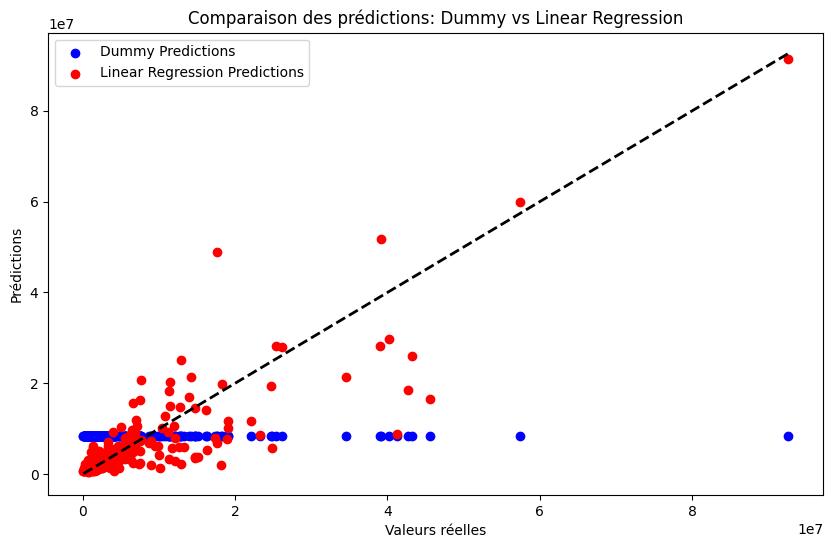

In [3507]:
representation_predictions(y_test,y_pred_dummy,y_pred_elastic)

# DECISION TREE REGRESSOR

Score R² train : 0.60
Score R² test : 0.61
Score MAE train : 4.51e+06
Score MAE test : 3.31e+06
Score MAPE train : 116.73 %
Score MAPE test : 112.27 %
Score MSE train : 1.76e+14
Score MSE test : 3.84e+13


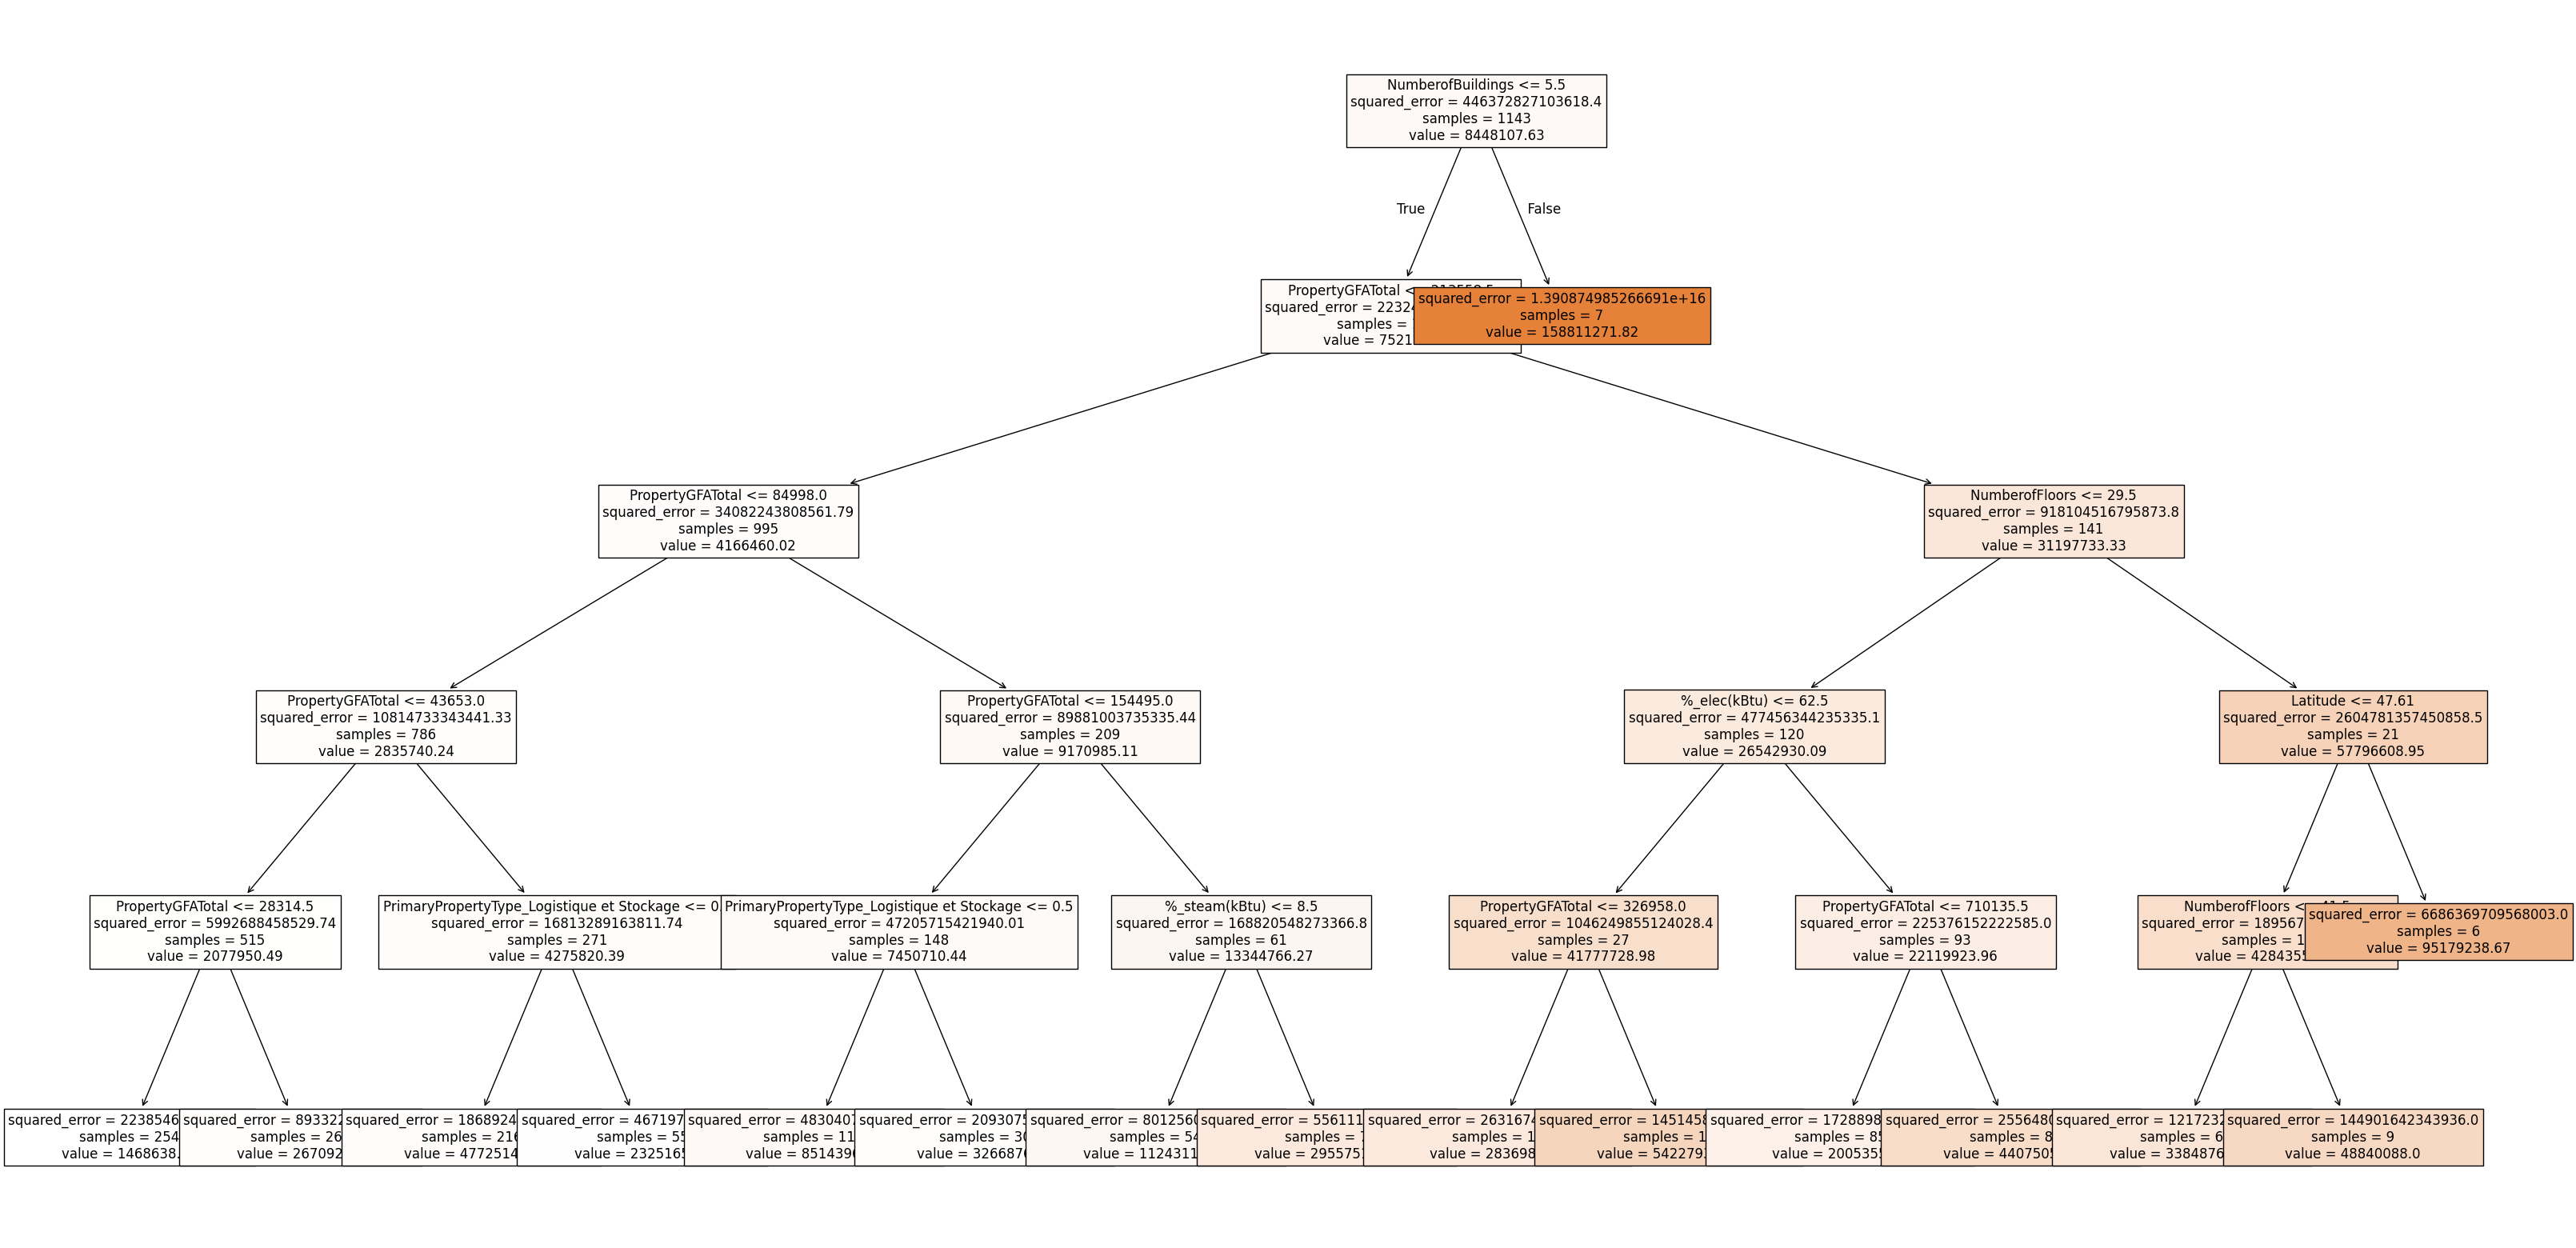

In [3508]:
dt_reg,MAE,MAPE,MSE,R2=decision_tree_regressor(DF_cleaned,col_num,TARGET,'RAS',['None'],
                                               Tableau_score_mae,Tableau_score_mape,
                                               Tableau_score_mse,Tableau_score_r2)

## FEATURE IMPORTANCE

In [3509]:
from sklearn.model_selection import train_test_split

X=DF_cleaned[col_num]
y=DF_cleaned[TARGET]



X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


# Récupérer directement les importances et les noms des features
importances = dt_reg.feature_importances_
feature_names = X_train.columns

# Créer un dictionnaire simple
importances_dict = dict(zip(feature_names, importances))

# Trier par importance décroissante
sorted_importances = dict(sorted(importances_dict.items(), key=lambda x: x[1], reverse=True))

col_num_sel_dt=[]

# Afficher les résultats
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")
    if importance>0.0 and feature not in ['AGE','OSEBuildingID']:
        col_num_sel_dt.append(feature)

NumberofBuildings: 0.5162
PropertyGFATotal: 0.3506
NumberofFloors: 0.0592
Latitude: 0.0381
%_elec(kBtu): 0.0262
%_steam(kBtu): 0.0067
PrimaryPropertyType_Logistique et Stockage: 0.0030
ZipCode: 0.0000
CouncilDistrictCode: 0.0000
Longitude: 0.0000
AGE: 0.0000
%_gas(kBtu): 0.0000
%_parking: 0.0000
%_immeuble: 0.0000
PrimaryPropertyType_Education et Services Communautaires: 0.0000
PrimaryPropertyType_Immobilier Commercial: 0.0000
PrimaryPropertyType_Santé: 0.0000


In [3510]:
print(col_num_sel_dt)

['NumberofBuildings', 'PropertyGFATotal', 'NumberofFloors', 'Latitude', '%_elec(kBtu)', '%_steam(kBtu)', 'PrimaryPropertyType_Logistique et Stockage']


## ESSAI AVEC LES FEATURE D'IMPORTANCE SUP A 0 ET EN LOGANT LA CIBLE ET PROPERTYGFA

Score R² train : 0.55
Score R² test : 0.41
Score MAE train : 3.92e+06
Score MAE test : 3.10e+06
Score MAPE train : 59.23 %
Score MAPE test : 70.48 %
Score MSE train : 2.01e+14
Score MSE test : 5.81e+13


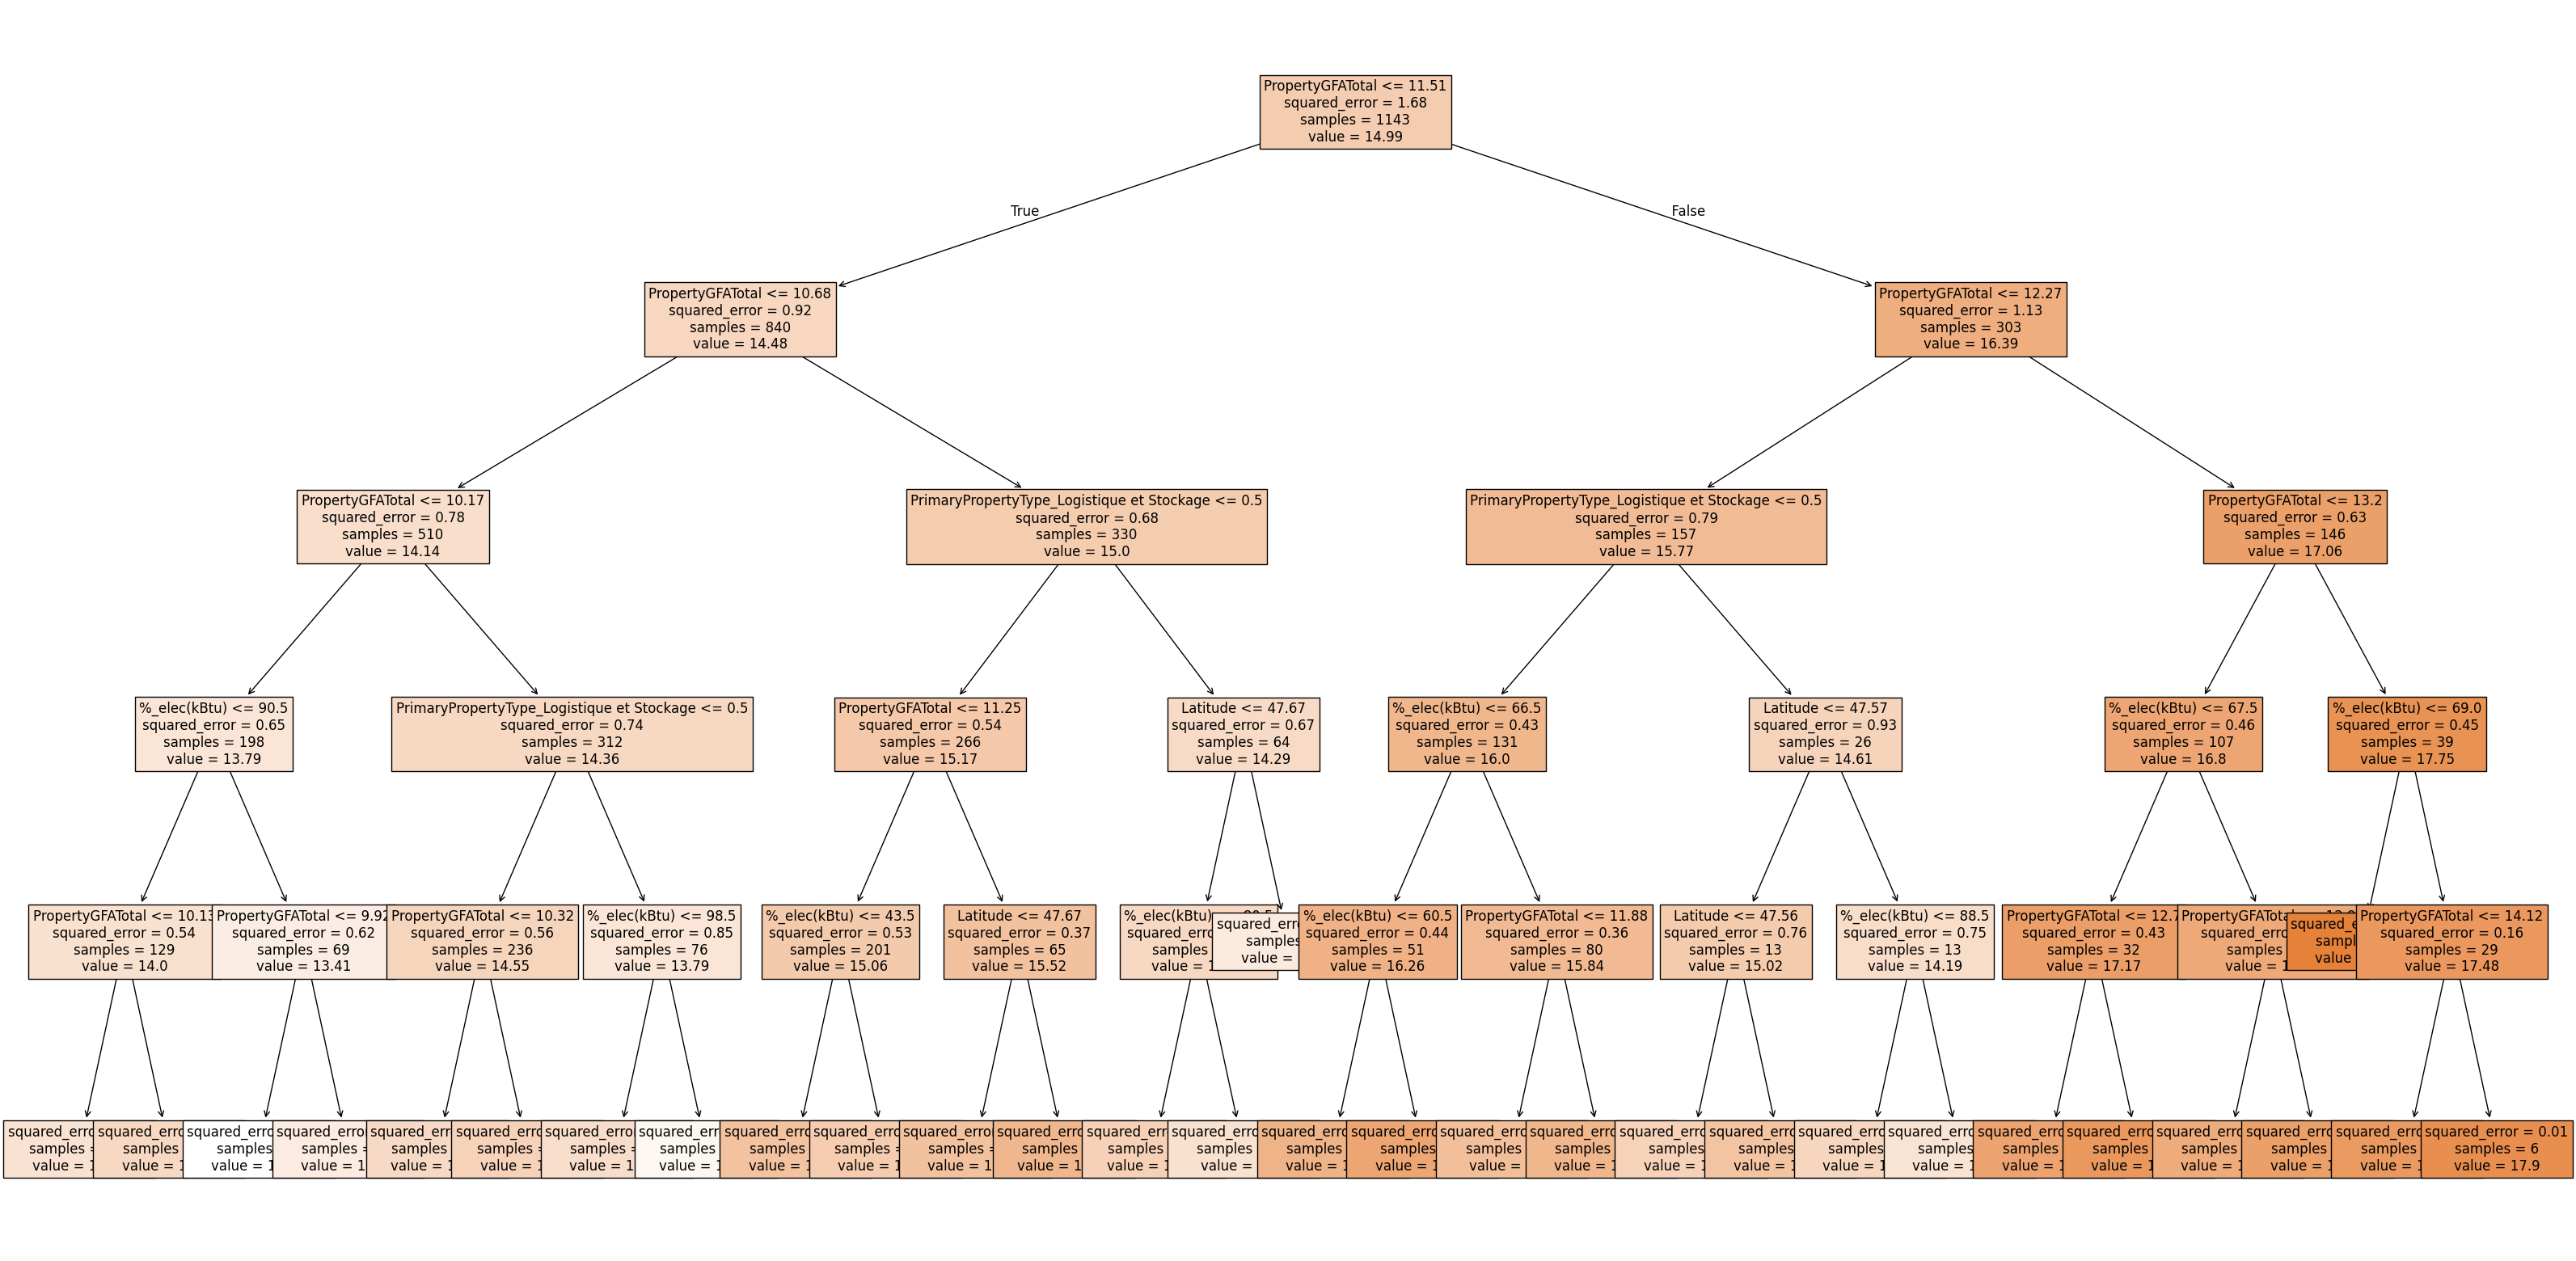

In [3511]:
dtr,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2=\
    decision_tree_regressor(DF_cleaned,col_num_sel_dt,TARGET,'log_target_feature',['PropertyGFATotal'],
                            Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

In [3512]:
nouvelle_ligne=pd.Series([len(col_num_sel_dt)],index=['Nbre Feature Pertinentes']).to_frame().T
nouvelle_ligne.index=['Decision Tree']

Tableau_score_feature=pd.concat([Tableau_score_feature,nouvelle_ligne])

# RANDOM FOREST

In [3513]:
rf_reg,MAE,MAPE,MSE,R2=random_forest(DF_cleaned,col_num,TARGET,'RAS',['None']
                     ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.72
Score R² test : 0.59
Score MAE train : 3.49e+06
Score MAE test : 3.24e+06
Score MAPE train : 74.66 %
Score MAPE test : 92.20 %
Score MSE train : 1.25e+14
Score MSE test : 4.02e+13


## PERMUTATION POUR FEATURE IMPORTANCE

In [3514]:
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split

X=DF_cleaned[col_num]
y=DF_cleaned[TARGET]




X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Calcul des permutation importances
result = permutation_importance(
   rf_reg, 
   X_test,  # On utilise le jeu de test pour éviter le biais
   y_test,
   n_repeats=10,  # Nombre de permutations à effectuer
   random_state=42
)

# Création d'un dictionnaire avec les importances moyennes
importances = result.importances_mean
feature_names = X_test.columns
importances_dict = dict(zip(feature_names, importances))

# Tri par importance décroissante
sorted_importances = dict(sorted(importances_dict.items(), key=lambda x: x[1], reverse=True))

col_num_sel_rf=[]

# Affichage des résultats avec les écarts-types
for feature, importance in sorted_importances.items():
   std = result.importances_std[list(feature_names).index(feature)]
   print(f"{feature}: {importance:.4f} (±{std:.4f})")
   if importance>0.02 and feature not in ['AGE','OSEBuildingID']:
      col_num_sel_rf.append(feature)

PropertyGFATotal: 1.8835 (±0.2279)
PrimaryPropertyType_Immobilier Commercial: 0.0673 (±0.0610)
%_elec(kBtu): 0.0669 (±0.0481)
AGE: 0.0309 (±0.0137)
PrimaryPropertyType_Logistique et Stockage: 0.0292 (±0.0055)
%_gas(kBtu): 0.0203 (±0.0071)
ZipCode: 0.0029 (±0.0040)
Longitude: 0.0026 (±0.0098)
%_parking: 0.0007 (±0.0006)
PrimaryPropertyType_Education et Services Communautaires: 0.0004 (±0.0009)
%_immeuble: -0.0011 (±0.0040)
CouncilDistrictCode: -0.0014 (±0.0031)
NumberofBuildings: -0.0022 (±0.0017)
NumberofFloors: -0.0032 (±0.0160)
%_steam(kBtu): -0.0049 (±0.0123)
PrimaryPropertyType_Santé: -0.0094 (±0.0075)
Latitude: -0.0158 (±0.0122)


In [3515]:
print(col_num_sel_rf)

['PropertyGFATotal', 'PrimaryPropertyType_Immobilier Commercial', '%_elec(kBtu)', 'PrimaryPropertyType_Logistique et Stockage', '%_gas(kBtu)']


## ESSAI AVEC LES FEATURES LES PLUS PERTINENTES + LOG

In [3516]:
rfreg,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2=\
random_forest(DF_cleaned,col_num_sel_rf,TARGET,'log_target_feature',['PropertyGFATotal']
              ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.60
Score R² test : 0.63
Score MAE train : 3.41e+06
Score MAE test : 2.90e+06
Score MAPE train : 47.02 %
Score MAPE test : 62.29 %
Score MSE train : 1.80e+14
Score MSE test : 3.63e+13


In [3517]:
nouvelle_ligne=pd.Series([len(col_num_sel_rf)],index=['Nbre Feature Pertinentes']).to_frame().T
nouvelle_ligne.index=['Random Forest']

Tableau_score_feature=pd.concat([Tableau_score_feature,nouvelle_ligne])

# GRADIENT BOOSTING 

In [3518]:
gb_reg,MAE,MAPE,MSE,R2=gradient_boosting(DF_cleaned,col_num,TARGET,'RAS',['None']
                         ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.78
Score R² test : 0.52
Score MAE train : 4.05e+06
Score MAE test : 3.50e+06
Score MAPE train : 137.58 %
Score MAPE test : 143.09 %
Score MSE train : 9.92e+13
Score MSE test : 4.71e+13


## PERMUTATION POUR FEATURE IMPORTANCE

In [3519]:
from sklearn.inspection import permutation_importance

X=DF_cleaned[col_num]
y=DF_cleaned[TARGET]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Calcul des permutation importances pour le Gradient Boosting
result = permutation_importance(
   gb_reg, 
   X_test,
   y_test,
   n_repeats=10,
   random_state=42
)

# Création d'un dictionnaire avec les importances moyennes
importances = result.importances_mean
feature_names = X_test.columns
importances_dict = dict(zip(feature_names, importances))

# Tri par importance décroissante
sorted_importances = dict(sorted(importances_dict.items(), key=lambda x: x[1], reverse=True))

col_num_sel_gb=[]

# Affichage des résultats avec les écarts-types
for feature, importance in sorted_importances.items():
   std = result.importances_std[list(feature_names).index(feature)]
   print(f"{feature}: {importance:.4f} (±{std:.4f})")
   if importance>0.01 and feature!='AGE':
      col_num_sel_gb.append(feature)

PropertyGFATotal: 1.5978 (±0.2739)
%_elec(kBtu): 0.0727 (±0.0865)
NumberofFloors: 0.0303 (±0.0154)
%_steam(kBtu): 0.0227 (±0.0365)
PrimaryPropertyType_Immobilier Commercial: 0.0087 (±0.0582)
AGE: 0.0085 (±0.0100)
PrimaryPropertyType_Logistique et Stockage: 0.0043 (±0.0015)
%_gas(kBtu): 0.0022 (±0.0059)
ZipCode: 0.0008 (±0.0036)
CouncilDistrictCode: 0.0000 (±0.0000)
PrimaryPropertyType_Education et Services Communautaires: 0.0000 (±0.0000)
NumberofBuildings: -0.0005 (±0.0019)
Longitude: -0.0018 (±0.0077)
%_parking: -0.0025 (±0.0046)
%_immeuble: -0.0064 (±0.0051)
Latitude: -0.0079 (±0.0059)
PrimaryPropertyType_Santé: -0.0274 (±0.0275)


In [3520]:
print(col_num_sel_gb)

['PropertyGFATotal', '%_elec(kBtu)', 'NumberofFloors', '%_steam(kBtu)']


## ESSAI AVEC SEULEMENT LES FEATURES QUI DEPASSENT 1% + LOG

In [3521]:
gbreg,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2=\
    gradient_boosting(DF_cleaned,col_num_sel_gb,TARGET,'log_target_feature',['PropertyGFATotal']
                  ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.60
Score R² test : 0.65
Score MAE train : 3.84e+06
Score MAE test : 2.85e+06
Score MAPE train : 68.31 %
Score MAPE test : 71.04 %
Score MSE train : 1.77e+14
Score MSE test : 3.37e+13


In [3522]:
nouvelle_ligne=pd.Series([len(col_num_sel_gb)],index=['Nbre Feature Pertinentes']).to_frame().T
nouvelle_ligne.index=['Gradient Boosting']

Tableau_score_feature=pd.concat([Tableau_score_feature,nouvelle_ligne])

# XGBoost

In [3523]:
xgb_reg,MAE,MAPE,MSE,R2=xgboost_reg(DF_cleaned,col_num,TARGET,'RAS',['None']
                    ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.82
Score R² test : 0.55
Score MAE train : 3.84e+06
Score MAE test : 3.51e+06
Score MAPE train : 124.57 %
Score MAPE test : 133.56 %
Score MSE train : 8.18e+13
Score MSE test : 4.44e+13


## ESSAI DE PERMUTATION DES FEATURE

In [3524]:
X=DF_cleaned[col_num]
y=DF_cleaned[TARGET]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


# Obtenir le booster sous-jacent
booster = xgb_reg.get_booster()

# Obtenir l'importance basée sur le gain
importance_dict = booster.get_score(importance_type='gain')

# Convertir en dictionnaire avec toutes les features (même celles avec gain=0)
all_features = X_train.columns
importance_dict_full = {feat: importance_dict.get(feat, 0) for feat in all_features}

# Trier par importance décroissante
sorted_importances = dict(sorted(importance_dict_full.items(), key=lambda x: x[1], reverse=True))

col_num_sel_xgb=[]

# Afficher les résultats
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")
    if importance>3448119467442176 and feature!='OSEBuildingID':
        col_num_sel_xgb.append(feature)

PrimaryPropertyType_Immobilier Commercial: 15326327729029120.0000
NumberofBuildings: 14881751369252864.0000
PrimaryPropertyType_Santé: 10455187349045248.0000
PropertyGFATotal: 9237536203341824.0000
%_elec(kBtu): 6426467223207936.0000
Longitude: 3918744803868672.0000
NumberofFloors: 3881739365646336.0000
CouncilDistrictCode: 3540429588922368.0000
%_parking: 3424952413847552.0000
%_steam(kBtu): 3315520405241856.0000
ZipCode: 2873987029794816.0000
Latitude: 2706101053161472.0000
%_immeuble: 2150076197634048.0000
AGE: 1456793179914240.0000
PrimaryPropertyType_Logistique et Stockage: 750126574338048.0000
%_gas(kBtu): 687193425182720.0000
PrimaryPropertyType_Education et Services Communautaires: 0.0000


In [3525]:
print(col_num_sel_xgb)

['PrimaryPropertyType_Immobilier Commercial', 'NumberofBuildings', 'PrimaryPropertyType_Santé', 'PropertyGFATotal', '%_elec(kBtu)', 'Longitude', 'NumberofFloors', 'CouncilDistrictCode']


## ESSAI AVEC JUSTE LES FEATURE UTILES

In [3526]:
xgbreg,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2=\
    xgboost_reg(DF_cleaned,col_num_sel_xgb,TARGET,'log_target_feature',['PropertyGFATotal'],
            Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.72
Score R² test : 0.60
Score MAE train : 3.51e+06
Score MAE test : 2.90e+06
Score MAPE train : 62.74 %
Score MAPE test : 66.26 %
Score MSE train : 1.26e+14
Score MSE test : 3.90e+13


In [3527]:
nouvelle_ligne=pd.Series([len(col_num_sel_xgb)],index=['Nbre Feature Pertinentes']).to_frame().T
nouvelle_ligne.index=['XGBoost']

Tableau_score_feature=pd.concat([Tableau_score_feature,nouvelle_ligne])

# SVR

In [3528]:
svr_reg(DF_cleaned,col_num,TARGET,'RAS',['None']
        ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.43
Score R² test : 0.59
Score MAE train : 3.88e+06
Score MAE test : 3.17e+06
Score MAPE train : 101.06 %
Score MAPE test : 128.97 %
Score MSE train : 2.55e+14
Score MSE test : 3.96e+13


(                      train      test   general
 Reg_lin            4.00e+06  2.74e+06  3.75e+06
 ElasticNet         3.97e+06  2.65e+06  3.70e+06
 Decision Tree      3.92e+06  3.10e+06  3.76e+06
 Random Forest      3.41e+06  2.90e+06  3.31e+06
 Gradient Boosting  3.84e+06  2.85e+06  3.65e+06
 XGBoost            3.51e+06  2.90e+06  3.39e+06
 SVR                3.88e+06  3.17e+06  3.74e+06,
                     train    test general
 Reg_lin             69.42   67.01   68.94
 ElasticNet          69.22   67.12   68.80
 Decision Tree       59.23   70.48   61.48
 Random Forest       47.02   62.29   50.08
 Gradient Boosting   68.31   71.04   68.86
 XGBoost             62.74   66.26   63.44
 SVR                101.06  128.97  106.64,
                       train      test   general
 Reg_lin            1.46e+14  2.99e+13  1.23e+14
 ElasticNet         1.50e+14  2.82e+13  1.26e+14
 Decision Tree      2.01e+14  5.81e+13  1.72e+14
 Random Forest      1.80e+14  3.63e+13  1.51e+14
 Gradient Boostin

## PERMUTATIONS POUR FEATURE IMPORTANCE

In [3529]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

X=DF_cleaned[col_num]
y=DF_cleaned[TARGET]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Scaling des données log-transformées
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaling de y aussi
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Création du modèle
svr = SVR(
   kernel='rbf',
   C=1.0,
   epsilon=0.1,
   gamma='scale'
)

# Entraînement
svr.fit(X_train_scaled, y_train_scaled)


# Calcul des permutation importances pour le SVR
result = permutation_importance(
   svr, 
   X_test_scaled,
   y_test_scaled,
   n_repeats=10,
   random_state=42
)

# Création d'un dictionnaire avec les importances moyennes
importances = result.importances_mean
feature_names = X_test.columns
importances_dict = dict(zip(feature_names, importances))

# Tri par importance décroissante
sorted_importances = dict(sorted(importances_dict.items(), key=lambda x: x[1], reverse=True))

col_num_sel_svr=[]

# Affichage des résultats avec les écarts-types
for feature, importance in sorted_importances.items():
   std = result.importances_std[list(feature_names).index(feature)]
   print(f"{feature}: {importance:.4f} (±{std:.4f})")
   if importance>0.03:
      col_num_sel_svr.append(feature)

PropertyGFATotal: 0.6530 (±0.0701)
PrimaryPropertyType_Santé: 0.0472 (±0.0074)
PrimaryPropertyType_Immobilier Commercial: 0.0425 (±0.0090)
%_elec(kBtu): 0.0423 (±0.0093)
%_gas(kBtu): 0.0400 (±0.0089)
%_steam(kBtu): 0.0358 (±0.0129)
ZipCode: 0.0299 (±0.0075)
%_parking: 0.0282 (±0.0034)
%_immeuble: 0.0282 (±0.0034)
PrimaryPropertyType_Logistique et Stockage: 0.0266 (±0.0064)
CouncilDistrictCode: 0.0212 (±0.0058)
PrimaryPropertyType_Education et Services Communautaires: 0.0198 (±0.0078)
AGE: 0.0183 (±0.0079)
Latitude: 0.0124 (±0.0075)
NumberofFloors: 0.0102 (±0.0083)
Longitude: 0.0080 (±0.0067)
NumberofBuildings: 0.0024 (±0.0044)


In [3530]:
print(col_num_sel_svr)
del(col_num_sel_svr[col_num_sel_svr.index('%_gas(kBtu)')])

['PropertyGFATotal', 'PrimaryPropertyType_Santé', 'PrimaryPropertyType_Immobilier Commercial', '%_elec(kBtu)', '%_gas(kBtu)', '%_steam(kBtu)']


## ESSAI AVEC REDUCTION DE FEATURE + LOG

In [3531]:
Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2=\
        svr_reg(DF_cleaned,col_num_sel_svr,TARGET,'log_target_feature',['PropertyGFATotal']
        ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.58
Score R² test : 0.62
Score MAE train : 3.76e+06
Score MAE test : 2.79e+06
Score MAPE train : 62.26 %
Score MAPE test : 64.63 %
Score MSE train : 1.88e+14
Score MSE test : 3.68e+13


In [3532]:
nouvelle_ligne=pd.Series([len(col_num_sel_svr)],index=['Nbre Feature Pertinentes']).to_frame().T
nouvelle_ligne.index=['SVR']

Tableau_score_feature=pd.concat([Tableau_score_feature,nouvelle_ligne])

# NN


In [3533]:
nn_reg_mod,MAE,MAPE,MSE,R2,scal,scaly=nn_reg_fonc(DF_cleaned,col_num,TARGET,'RAS',['None'],
                       Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.90
Score R² test : 0.35
Score MAE train : 3.23e+06
Score MAE test : 3.62e+06
Score MAPE train : 83.32 %
Score MAPE test : 103.01 %
Score MSE train : 4.30e+13
Score MSE test : 6.39e+13


## PERMUTATIONS

In [3534]:
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X=DF_cleaned[col_num]
y=DF_cleaned[TARGET]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Scaling des données log-transformées
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaling de y aussi
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Calcul des permutation importances pour le Neural Network
result = permutation_importance(
    nn_reg_mod, 
    X_test_scaled,
    y_test_scaled,
    n_repeats=10,
    random_state=42
)

# Utilisation des noms de colonnes originaux
feature_names = X_test.columns  # ou X_train_log.columns selon ce que vous avez

# Création d'un dictionnaire avec les importances moyennes
importances = result.importances_mean
importances_dict = dict(zip(feature_names, importances))

# Tri par importance décroissante
sorted_importances = dict(sorted(importances_dict.items(), key=lambda x: x[1], reverse=True))

col_num_sel_nn=[]

# Affichage des résultats avec les écarts-types
for feature, importance in sorted_importances.items():
    std = result.importances_std[list(feature_names).index(feature)]
    print(f"{feature}: {importance:.4f} (±{std:.4f})")
    if importance>0.006 and feature not in ['AGE','OSEBuildingID']:
        col_num_sel_nn.append(feature)

PropertyGFATotal: 1.4258 (±0.2437)
PrimaryPropertyType_Immobilier Commercial: 0.8903 (±0.2670)
NumberofFloors: 0.4173 (±0.2183)
%_gas(kBtu): 0.2004 (±0.0499)
%_elec(kBtu): 0.1546 (±0.0547)
AGE: 0.1101 (±0.0657)
ZipCode: 0.0610 (±0.0518)
CouncilDistrictCode: 0.0451 (±0.0326)
Latitude: 0.0234 (±0.0377)
%_steam(kBtu): 0.0107 (±0.1190)
PrimaryPropertyType_Logistique et Stockage: -0.0014 (±0.0469)
PrimaryPropertyType_Education et Services Communautaires: -0.0031 (±0.0413)
NumberofBuildings: -0.0146 (±0.0242)
%_parking: -0.0215 (±0.0375)
%_immeuble: -0.0476 (±0.0435)
Longitude: -0.0481 (±0.0448)
PrimaryPropertyType_Santé: -0.1452 (±0.0583)


In [3535]:

print(col_num_sel_nn)

['PropertyGFATotal', 'PrimaryPropertyType_Immobilier Commercial', 'NumberofFloors', '%_gas(kBtu)', '%_elec(kBtu)', 'ZipCode', 'CouncilDistrictCode', 'Latitude', '%_steam(kBtu)']


## ESSAI AVEC SEULEMENT LES FEATURE IMPORTANTES + LOG

In [3536]:
nnreg,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2,scalerX,scalerY=\
    nn_reg_fonc(DF_cleaned,col_num_sel_nn,TARGET,'log_target_feature',['PropertyGFATotal']
            ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2)

Score R² train : 0.71
Score R² test : 0.49
Score MAE train : 3.64e+06
Score MAE test : 3.23e+06
Score MAPE train : 70.99 %
Score MAPE test : 79.93 %
Score MSE train : 1.30e+14
Score MSE test : 4.99e+13


In [3537]:
nouvelle_ligne=pd.Series([len(col_num_sel_nn)],index=['Nbre Feature Pertinentes']).to_frame().T
nouvelle_ligne.index=['NN']

Tableau_score_feature=pd.concat([Tableau_score_feature,nouvelle_ligne])

# AFFICHAGE DES SCORES

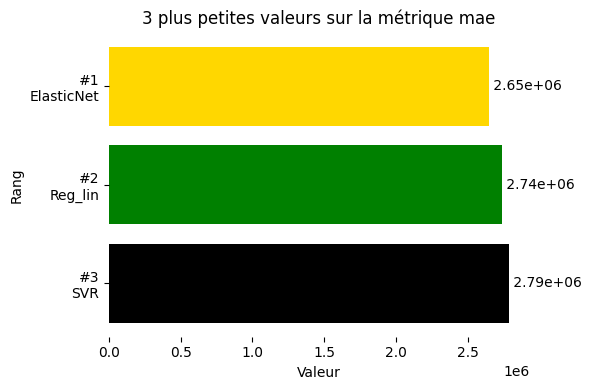


Bottom 3 des valeurs:
#3: Modéle SVR, Valeur: 2.79e+06
#2: Modéle Reg_lin, Valeur: 2.74e+06
#1: Modéle ElasticNet, Valeur: 2.65e+06


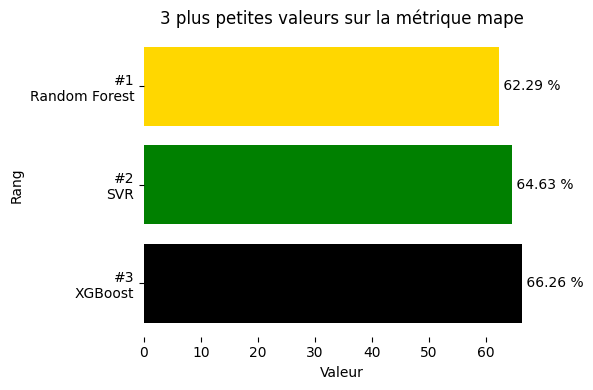


Bottom 3 des valeurs:
#3: Modéle XGBoost, Valeur: 66.26 %
#2: Modéle SVR, Valeur: 64.63 %
#1: Modéle Random Forest, Valeur: 62.29 %


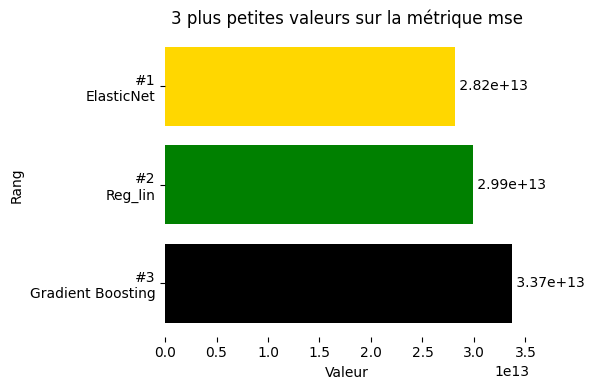


Bottom 3 des valeurs:
#3: Modéle Gradient Boosting, Valeur: 3.37e+13
#2: Modéle Reg_lin, Valeur: 2.99e+13
#1: Modéle ElasticNet, Valeur: 2.82e+13


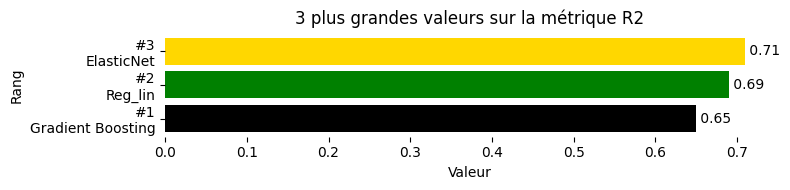


Top 3 des valeurs:
#2: Index Gradient Boosting, Valeur: 0.65
#1: Index Reg_lin, Valeur: 0.69
#0: Index ElasticNet, Valeur: 0.71


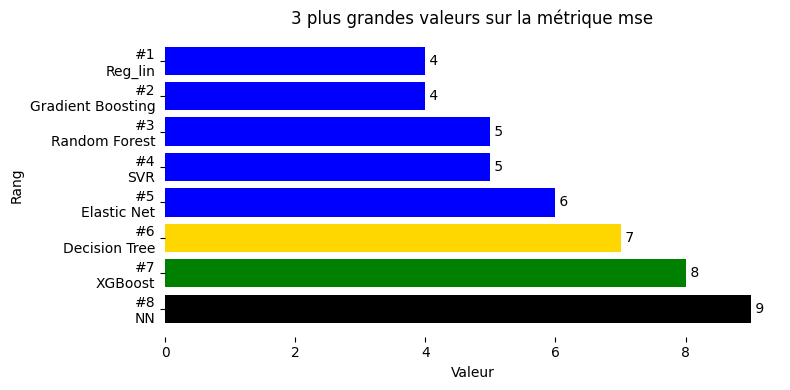

In [3538]:
for DF,nom in [(Tableau_score_mae,'Tableau_score_mae'),(Tableau_score_mape,'Tableau_score_mape'),\
           (Tableau_score_mse,'Tableau_score_mse')]:
    
    DF['test']=pd.to_numeric(DF['test'])

    plt.rcParams['figure.max_open_warning'] = False
    plt.rcParams['agg.path.chunksize'] = 1000

    # Sélection des 3 plus petites valeurs
    bottom3_series = DF['test'].nsmallest(3)[::-1]
    bottom3_indices = bottom3_series.index
    bottom3_values = bottom3_series.values

    # Définition des couleurs
    colors = {
        2: 'gold',    # Or
        1: 'green',    # Argent
        0: 'black'     # Bronze
    }

    # Création de la figure avec taille contrôlée
    fig, ax = plt.subplots(figsize=(6, 4))  # Taille réduite et contrôlée

    # Création du graphique horizontal
    barh = ax.barh(range(3), bottom3_values, color=[colors[i] for i in range(3)])

    # Personnalisation du graphique
    ax.set_title(f'3 plus petites valeurs sur la métrique {nom.split('_')[-1]}')
    ax.set_xlabel('Valeur')
    ax.set_ylabel('Rang')

    # Personnalisation des labels de l'axe y
    ax.set_yticks(range(3))
    ax.set_yticklabels([f"#{3-i}\n{idx}" for i, idx in enumerate(bottom3_indices)])

    # Retirer le cadre
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Ajout des valeurs sur les barres
    for i, value in enumerate(bottom3_values):
        if nom in ['Tableau_score_mae','Tableau_score_mse']:
            ax.text(value, i, f' {value:.2e}', va='center')
        else:
            ax.text(value, i, f' {value:.2f} %', va='center')
    # Ajuster les marges
    plt.tight_layout()

    plt.show()

    # Affichage des valeurs dans le terminal
    print("\nBottom 3 des valeurs:")
    for i, (idx, val) in enumerate(zip(bottom3_indices, bottom3_values), 1):
        if nom in ['Tableau_score_mae','Tableau_score_mse']:
            print(f"#{4-i}: Modéle {idx}, Valeur: {val:.2e}")
        else:
            print(f"#{4-i}: Modéle {idx}, Valeur: {val:.2f} %")


Tableau_score_r2['test']=pd.to_numeric(Tableau_score_r2['test'])

plt.rcParams['figure.max_open_warning'] = False
plt.rcParams['agg.path.chunksize'] = 1000

# Sélection des 3 plus petites valeurs
bottom3_series = Tableau_score_r2['test'].nlargest(3)[::-1]
bottom3_indices = bottom3_series.index
bottom3_values = bottom3_series.values

# Définition des couleurs
colors = {
    2: 'gold',    # Or
    1: 'green',    # Argent
    0: 'black'     # Bronze
}

# Création de la figure avec taille contrôlée
fig, ax = plt.subplots(figsize=(8, 2))  # Taille réduite et contrôlée

# Création du graphique horizontal
barh = ax.barh(range(3), bottom3_values, color=[colors[i] for i in range(3)])

# Personnalisation du graphique
ax.set_title('3 plus grandes valeurs sur la métrique R2')
ax.set_xlabel('Valeur')
ax.set_ylabel('Rang')

# Personnalisation des labels de l'axe y
ax.set_yticks(range(3))
ax.set_yticklabels([f"#{i+1}\n{idx}" for i, idx in enumerate(bottom3_indices)])

# Retirer le cadre
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Ajout des valeurs sur les barres
for i, value in enumerate(bottom3_values):
    ax.text(value, i, f' {value:.2f}', va='center')

# Ajuster les marges
plt.tight_layout()

plt.show()

# Affichage des valeurs dans le terminal
print("\nTop 3 des valeurs:")
for i, (idx, val) in enumerate(zip(bottom3_indices, bottom3_values), 1):
    print(f"#{3-i}: Index {idx}, Valeur: {val:.2f}")


Tableau_score_feature['Nbre Feature Pertinentes']=\
    pd.to_numeric(Tableau_score_feature['Nbre Feature Pertinentes'])

plt.rcParams['figure.max_open_warning'] = False
plt.rcParams['agg.path.chunksize'] = 1000

# Sélection des 3 plus petites valeurs
bottom3_series = Tableau_score_feature['Nbre Feature Pertinentes']\
    .nsmallest(len(Tableau_score_feature['Nbre Feature Pertinentes']))[::-1]
bottom3_indices = bottom3_series.index
bottom3_values = bottom3_series.values

# Définition des couleurs
colors = {
    8:'blue',
    7:'blue',
    6:'blue',
    5:'blue',
    4:'blue',
    3:'blue',
    2: 'gold',    # Or
    1: 'green',    # Argent
    0: 'black'     # Bronze
}

# Création de la figure avec taille contrôlée
fig, ax = plt.subplots(figsize=(8, 4))  # Taille réduite et contrôlée

# Création du graphique horizontal
barh = ax.barh(range(8), bottom3_values, color=[colors[i] for i in range(8)])

# Personnalisation du graphique
ax.set_title(f'3 plus grandes valeurs sur la métrique {nom.split('_')[-1]}')
ax.set_xlabel('Valeur')
ax.set_ylabel('Rang')

# Personnalisation des labels de l'axe y
ax.set_yticks(range(8))
ax.set_yticklabels([f"#{8-i}\n{idx}" for i, idx in enumerate(bottom3_indices)])

# Retirer le cadre
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Ajout des valeurs sur les barres
for i, value in enumerate(bottom3_values):
    ax.text(value, i, f' {value}', va='center')
    
# Ajuster les marges
plt.tight_layout()

plt.show()


    



# GRID SEARCH

In [3539]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3540]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Grilles d'hyperparamètres étendues
param_grids = {
    'elastic': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0,0.1, 0.3, 0.4,0.5, 0.7, 0.9,1]
    },
    'rf': {
        'n_estimators': [ 50, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [ 5,10, 20,],
        'min_samples_leaf': [1, 2, 4, 8]
    },
    'gb': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [1, 3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.5, 0.7, 0.9, 1.0]
    }
}

def grid_search_elastic(DF, col_num, target, type, log_feature):
    """Grid search pour Elastic Net avec affichage minimal"""
    results = []
    best_r2 = -np.inf
    best_mape = np.inf
    
    total = len(param_grids['elastic']['alpha']) * len(param_grids['elastic']['l1_ratio'])
    with tqdm(total=total, desc="Elastic Net") as pbar:
        for alpha in param_grids['elastic']['alpha']:
            for l1_ratio in param_grids['elastic']['l1_ratio']:
                _, _, _, results_df, _, _, _ = reg_regul(
                    DF=DF,
                    col_num=col_num,
                    target=target,
                    type=type,
                    log_feature=log_feature,
                    alpha=alpha,
                    l1_ratio=l1_ratio
                )
                
                r2_value = float(results_df.loc['r2_ElasticNet_log_target_feature', 'test'])
                mape_value = float(results_df.loc['mape_ElasticNet_log_target_feature', 'test'])
                
                if r2_value > best_r2:
                    best_r2 = r2_value
                    print(f"\nElastic Net - Nouveau meilleur R² : {r2_value:.4f} avec alpha={alpha}, l1_ratio={l1_ratio}")
                
                if mape_value < best_mape:
                    best_mape = mape_value
                    print(f"\nElastic Net - Nouveau meilleur MAPE : {mape_value:.4f} avec alpha={alpha}, l1_ratio={l1_ratio}")
                
                results.append({
                    'alpha': alpha,
                    'l1_ratio': l1_ratio,
                    'r2_test': r2_value,
                    'mape_test': mape_value
                })
                pbar.update(1)
    
    return pd.DataFrame(results)

def grid_search_rf(DF, col_num, target, type, log_feature, MAE, MAPE, MSE, R2):
    """Grid search pour Random Forest avec affichage minimal"""
    results = []
    best_r2 = -np.inf
    best_mape = np.inf
    
    total = (len(param_grids['rf']['n_estimators']) * len(param_grids['rf']['max_depth']) * 
             len(param_grids['rf']['min_samples_split']) * len(param_grids['rf']['min_samples_leaf']))
    
    with tqdm(total=total, desc="Random Forest") as pbar:
        for n_estimators in param_grids['rf']['n_estimators']:
            for max_depth in param_grids['rf']['max_depth']:
                for min_samples_split in param_grids['rf']['min_samples_split']:
                    for min_samples_leaf in param_grids['rf']['min_samples_leaf']:
                        params={'n_estimators':n_estimators,
                                'max_depth':max_depth,
                                'min_samples_split':min_samples_split,
                                'min_samples_leaf':min_samples_leaf,
                                'random_state':42}
                        
                        _, new_MAE, new_MAPE, new_MSE, new_R2 = random_forest(
                            DF=DF,
                            col_num=col_num,
                            target=target,
                            type=type,
                            col_a_log=log_feature,
                            MAE=MAE.copy(),
                            MAPE=MAPE.copy(),
                            MSE=MSE.copy(),
                            R2=R2.copy(),
                            verbose=False,
                            params=params
                        )
                        
                        r2_value = float(new_R2.loc['Random Forest', 'test'])
                        mape_value = float(new_MAPE.loc['Random Forest', 'test'])
                        
                        if r2_value > best_r2:
                            best_r2 = r2_value
                            print(f"\nRF - Nouveau meilleur R² : {r2_value:.4f} avec n_est={n_estimators}, depth={max_depth}, split={min_samples_split}, leaf={min_samples_leaf}")
                        
                        if mape_value < best_mape:
                            best_mape = mape_value
                            print(f"\nRF - Nouveau meilleur MAPE : {mape_value:.4f} avec n_est={n_estimators}, depth={max_depth}, split={min_samples_split}, leaf={min_samples_leaf}")
                        
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'r2_test': r2_value,
                            'mape_test': mape_value
                        })
                        pbar.update(1)
    
    return pd.DataFrame(results)

def grid_search_gb(DF, col_num, target, type, log_feature, MAE, MAPE, MSE, R2):
    """Grid search pour Gradient Boosting avec affichage minimal"""
    results = []
    best_r2 = -np.inf
    best_mape = np.inf
    
    total = (len(param_grids['gb']['n_estimators']) * len(param_grids['gb']['max_depth']) * 
             len(param_grids['gb']['learning_rate']) * len(param_grids['gb']['subsample']))
    
    with tqdm(total=total, desc="Gradient Boosting") as pbar:
        for n_estimators in param_grids['gb']['n_estimators']:
            for max_depth in param_grids['gb']['max_depth']:
                for learning_rate in param_grids['gb']['learning_rate']:
                    for subsample in param_grids['gb']['subsample']:
                        gb_reg = GradientBoostingRegressor(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            subsample=subsample,
                            random_state=42
                        )
                        
                        _, new_MAE, new_MAPE, new_MSE, new_R2 = gradient_boosting(
                            DF=DF,
                            col_num=col_num,
                            target=target,
                            type=type,
                            col_a_log=log_feature,
                            MAE=MAE.copy(),
                            MAPE=MAPE.copy(),
                            MSE=MSE.copy(),
                            R2=R2.copy(),
                            verbose=False
                        )
                        
                        r2_value = float(new_R2.loc['Gradient Boosting', 'test'])
                        mape_value = float(new_MAPE.loc['Gradient Boosting', 'test'])
                        
                        if r2_value > best_r2:
                            best_r2 = r2_value
                            print(f"\nGB - Nouveau meilleur R² : {r2_value:.4f} avec n_est={n_estimators}, depth={max_depth}, lr={learning_rate}, sub={subsample}")
                        
                        if mape_value < best_mape:
                            best_mape = mape_value
                            print(f"\nGB - Nouveau meilleur MAPE : {mape_value:.4f} avec n_est={n_estimators}, depth={max_depth}, lr={learning_rate}, sub={subsample}")
                        
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'r2_test': r2_value,
                            'mape_test': mape_value
                        })
                        pbar.update(1)
    
    return pd.DataFrame(results)



In [3541]:
# Initialisation
MAE = pd.DataFrame(columns=['train', 'test', 'general'])
MAPE = pd.DataFrame(columns=['train', 'test', 'general'])
MSE = pd.DataFrame(columns=['train', 'test', 'general'])
R2 = pd.DataFrame(columns=['train', 'test', 'general'])

# Exécution des grid searches
results_elastic = grid_search_elastic(
    DF=DF_cleaned_lineaire, 
    col_num=col_num_sel_regu,
    target='SiteEnergyUseWN(kBtu)',
    type='log_target_feature',
    log_feature=['PropertyGFATotal']
)

results_rf = grid_search_rf(
    DF=DF_cleaned, 
    col_num=col_num_sel_rf,
    target='SiteEnergyUseWN(kBtu)',
    type='log_target_feature',
    log_feature=['PropertyGFATotal'],
    MAE=MAE.copy(),
    MAPE=MAPE.copy(),
    MSE=MSE.copy(),
    R2=R2.copy()
)

results_gb = grid_search_gb(
    DF=DF_cleaned, 
    col_num=col_num_sel_gb,
    target='SiteEnergyUseWN(kBtu)',
    type='log_target_feature',
    log_feature=['PropertyGFATotal'],
    MAE=MAE.copy(),
    MAPE=MAPE.copy(),
    MSE=MSE.copy(),
    R2=R2.copy()
)

# Affichage des meilleurs résultats finaux
print("\n=== Résultats Finaux ===")
print("\nElastic Net - Meilleurs paramètres :")
print(results_elastic.sort_values('r2_test', ascending=False).head(1))

print("\nRandom Forest - Meilleurs paramètres :")
print(results_rf.sort_values('r2_test', ascending=False).head(1))


print("\nGradient Boosting - Meilleurs paramètres :")
print(results_gb.sort_values('r2_test', ascending=False).head(1))

Elastic Net:  10%|█         | 5/48 [00:00<00:00, 43.42it/s]


Elastic Net - Nouveau meilleur R² : 0.7000 avec alpha=0.0001, l1_ratio=0

Elastic Net - Nouveau meilleur MAPE : 67.1700 avec alpha=0.0001, l1_ratio=0

Elastic Net - Nouveau meilleur MAPE : 67.1600 avec alpha=0.001, l1_ratio=0.3

Elastic Net:  35%|███▌      | 17/48 [00:00<00:00, 48.04it/s]



Elastic Net - Nouveau meilleur MAPE : 67.1500 avec alpha=0.001, l1_ratio=0.9

Elastic Net - Nouveau meilleur R² : 0.7100 avec alpha=0.01, l1_ratio=0

Elastic Net - Nouveau meilleur MAPE : 67.1400 avec alpha=0.01, l1_ratio=0.3


Elastic Net:  58%|█████▊    | 28/48 [00:00<00:00, 48.80it/s]


Elastic Net - Nouveau meilleur MAPE : 67.1200 avec alpha=0.01, l1_ratio=0.4

Elastic Net - Nouveau meilleur MAPE : 67.1100 avec alpha=0.01, l1_ratio=0.5


Random Forest:   3%|▎         | 3/108 [00:00<00:10,  9.80it/s]


RF - Nouveau meilleur R² : 0.6500 avec n_est=50, depth=5, split=5, leaf=1

RF - Nouveau meilleur MAPE : 60.4300 avec n_est=50, depth=5, split=5, leaf=1

RF - Nouveau meilleur MAPE : 60.3800 avec n_est=50, depth=5, split=5, leaf=2

RF - Nouveau meilleur MAPE : 60.0400 avec n_est=50, depth=5, split=5, leaf=4


Random Forest:   6%|▋         | 7/108 [00:00<00:10,  9.98it/s]


RF - Nouveau meilleur R² : 0.6700 avec n_est=50, depth=5, split=10, leaf=1

RF - Nouveau meilleur MAPE : 59.9800 avec n_est=50, depth=5, split=10, leaf=2


Random Forest:  10%|█         | 11/108 [00:01<00:09,  9.90it/s]


RF - Nouveau meilleur MAPE : 59.8900 avec n_est=50, depth=5, split=20, leaf=1


Random Forest:  20%|██        | 22/108 [00:02<00:10,  7.93it/s]


RF - Nouveau meilleur R² : 0.6800 avec n_est=50, depth=10, split=20, leaf=1


Random Forest:  40%|███▉      | 43/108 [00:05<00:12,  5.24it/s]


RF - Nouveau meilleur MAPE : 59.8500 avec n_est=100, depth=5, split=10, leaf=2


Random Forest:  43%|████▎     | 46/108 [00:06<00:11,  5.27it/s]


RF - Nouveau meilleur MAPE : 59.6400 avec n_est=100, depth=5, split=20, leaf=1

RF - Nouveau meilleur MAPE : 59.6200 avec n_est=100, depth=5, split=20, leaf=2


Random Forest:  53%|█████▎    | 57/108 [00:08<00:12,  4.17it/s]


RF - Nouveau meilleur R² : 0.6900 avec n_est=100, depth=10, split=20, leaf=1

RF - Nouveau meilleur MAPE : 59.2800 avec n_est=100, depth=10, split=20, leaf=1


Gradient Boosting:   1%|          | 2/256 [00:00<00:27,  9.12it/s]


GB - Nouveau meilleur R² : 0.6500 avec n_est=50, depth=1, lr=0.01, sub=0.5

GB - Nouveau meilleur MAPE : 71.0400 avec n_est=50, depth=1, lr=0.01, sub=0.5


Gradient Boosting: 100%|██████████| 256/256 [00:28<00:00,  8.95it/s]


=== Résultats Finaux ===

Elastic Net - Meilleurs paramètres :
    alpha  l1_ratio  r2_test  mape_test
26    0.1       0.3     0.71      69.15

Random Forest - Meilleurs paramètres :
    n_estimators  max_depth  min_samples_split  min_samples_leaf  r2_test  \
56           100         10                 20                 1     0.69   

    mape_test  
56      59.28  

Gradient Boosting - Meilleurs paramètres :
   n_estimators  max_depth  learning_rate  subsample  r2_test  mape_test
0            50          1           0.01        0.5     0.65      71.04


In [3542]:
best_params_rf={'n_estimators':100,'max_depth':10,'min_samples_leaf':1,'min_samples_split':20,
                'random_state':42}

In [3543]:
ridge,lasso,elastic_log,resultats,y_test,y_pred_elastic,scl_log_ela_X=\
    reg_regul(DF_cleaned_lineaire,col_num_sel_regu,TARGET,type='log_target_feature',\
              log_feature=['PropertyGFATotal'],alpha=0.1,l1_ratio=0.3)

In [3544]:
rf_reg_log,MAE,MAPE,MSE,R2=\
    random_forest(DF_cleaned,col_num_sel_rf,TARGET,'log_target_feature',['PropertyGFATotal'],
                                         Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,
                                         Tableau_score_r2,True,best_params_rf)

Score R² train : 0.58
Score R² test : 0.69
Score MAE train : 3.48e+06
Score MAE test : 2.69e+06
Score MAPE train : 48.60 %
Score MAPE test : 59.28 %
Score MSE train : 1.88e+14
Score MSE test : 3.05e+13


# MIX

In [3545]:
print(col_num_sel_regu)
print(col_num_sel_rf)

['PropertyGFATotal', 'NumberofBuildings', 'PrimaryPropertyType_Santé', '%_steam(kBtu)', 'NumberofFloors', 'PrimaryPropertyType_Logistique et Stockage']
['PropertyGFATotal', 'PrimaryPropertyType_Immobilier Commercial', '%_elec(kBtu)', 'PrimaryPropertyType_Logistique et Stockage', '%_gas(kBtu)']


In [3546]:
from sklearn.metrics import mean_absolute_percentage_error

# Préparation des données
X_ela = DF_cleaned_lineaire[col_num_sel_regu]
X_ela['PropertyGFATotal'] = np.log(X_ela['PropertyGFATotal'])
X_ela_scaled = pd.DataFrame(
    scl_log_ela_X.transform(X_ela),
    index=X_ela.index,
    columns=X_ela.columns
)

X_rf = DF_cleaned[col_num_sel_rf]
X_rf['PropertyGFATotal'] = np.log(X_rf['PropertyGFATotal'])


y = np.log(DF_cleaned[TARGET])

# Train test split
X_ela_train, X_ela_test, y_train, y_test = train_test_split(
    X_ela_scaled, y,
    test_size=0.2,
    random_state=42
)

# Récupération des indices
train_indices = X_ela_train.index
test_indices = X_ela_test.index

# Application des mêmes indices pour X_rf
X_rf_train = X_rf.loc[train_indices]
X_rf_test = X_rf.loc[test_indices]

# Vérification de la cohérence
print("\nVérification de la cohérence :")
print(f"Même nombre d'observations train : {len(X_ela_train) == len(X_rf_train) == len(y_train)}")
print(f"Même nombre d'observations test : {len(X_ela_test) == len(X_rf_test) == len(y_test)}")

# Prédictions
y_train_pred_ela = elastic_log.predict(X_ela_train)
y_test_pred_ela = elastic_log.predict(X_ela_test)
y_general_pred_ela = elastic_log.predict(X_ela_scaled)

y_train_pred_rf = rf_reg_log.predict(X_rf_train)
y_test_pred_rf = rf_reg_log.predict(X_rf_test)
y_general_pred_rf = rf_reg_log.predict(X_rf)


# Conversion des y en valeurs non-log
y_train_exp = np.exp(y_train)
y_test_exp = np.exp(y_test)
y_exp = np.exp(y)

# Boucle sur les poids
for i in range(11):
    poids_1 = round(i/10,1)
    poids_2=round(1-poids_1,1)
    y_train_pred = poids_1 * y_train_pred_rf + poids_2 * y_train_pred_ela
    y_test_pred = poids_1 * y_test_pred_rf + poids_2 * y_test_pred_ela
    y_general_pred = poids_1 * y_general_pred_rf + poids_2 * y_general_pred_ela
    
    # Application de exp après la pondération
    y_train_pred_exp = np.exp(y_train_pred)
    y_test_pred_exp = np.exp(y_test_pred)
    y_general_pred_exp = np.exp(y_general_pred)
    
    print(f'\nPour une répartition {poids_1} RF/ {poids_2} Elastic on obtient les résultats suivants:')
    print(f'\nR2 TRAIN : {r2_score(y_train_exp, y_train_pred_exp):.2f}')
    print(f'R2 TEST : {r2_score(y_test_exp, y_test_pred_exp):.2f}')
    print(f'R2 global : {r2_score(y_exp, y_general_pred_exp):.2f}')
    print(f'\nMAPE TRAIN : {mean_absolute_percentage_error(y_train_exp, y_train_pred_exp)*100:.1f} %')
    print(f'MAPE TEST : {mean_absolute_percentage_error(y_test_exp, y_test_pred_exp)*100:.1f} %')
    print(f'MAPE GLOBAL : {mean_absolute_percentage_error(y_exp, y_general_pred_exp)*100:.1f} %')


Vérification de la cohérence :
Même nombre d'observations train : True
Même nombre d'observations test : True

Pour une répartition 0.0 RF/ 1.0 Elastic on obtient les résultats suivants:

R2 TRAIN : 0.57
R2 TEST : 0.71
R2 global : 0.58

MAPE TRAIN : 71.1 %
MAPE TEST : 69.1 %
MAPE GLOBAL : 70.7 %

Pour une répartition 0.1 RF/ 0.9 Elastic on obtient les résultats suivants:

R2 TRAIN : 0.57
R2 TEST : 0.71
R2 global : 0.58

MAPE TRAIN : 67.7 %
MAPE TEST : 67.0 %
MAPE GLOBAL : 67.6 %

Pour une répartition 0.2 RF/ 0.8 Elastic on obtient les résultats suivants:

R2 TRAIN : 0.57
R2 TEST : 0.72
R2 global : 0.58

MAPE TRAIN : 64.6 %
MAPE TEST : 65.0 %
MAPE GLOBAL : 64.7 %

Pour une répartition 0.3 RF/ 0.7 Elastic on obtient les résultats suivants:

R2 TRAIN : 0.58
R2 TEST : 0.72
R2 global : 0.58

MAPE TRAIN : 61.7 %
MAPE TEST : 63.3 %
MAPE GLOBAL : 62.1 %

Pour une répartition 0.4 RF/ 0.6 Elastic on obtient les résultats suivants:

R2 TRAIN : 0.58
R2 TEST : 0.73
R2 global : 0.59

MAPE TRAIN : 5

EN REALISANT UN MIX DES PREDICTIONS ENTRE LE MEILLEUR MODELE R2 (ELASTICNET) ET LE MEILLEUR MODELE MAPE (RANDOM FOREST) AVEC DES POIDS DE 50/50 ON OBTIENT LE MEILLEUR COMPROMIS ENTRE R2 (0.73) ET MAPE (60.7 %). ON POURRAIT AMELIORER LA MAPE MAIS CELA DEGRADERAI LE R2

# ETUDE SUR LES BATIMENTS RECENTS

ON VA SIMULER LES PERFORMANCES DE NOTRE MODELE COMME S'IL AVAIT ETE ENTRAINE IL Y A DIX ANS ET AVAIT TOURNE EN PRODUCTION DURANT CES DIX ANNEES

In [3547]:
DF_cleaned['AGE'].min()

9

In [3548]:
DF_cleaned_lineaire_age=DF_cleaned_lineaire.loc[DF_cleaned['AGE']>=18]
DF_cleaned_lineaire_age.shape

(1330, 34)

ON VA ENTRAINER ET FITTER NOTRE MODELE SUR LES DONNEES DU DATAFRAME DF_cleaned_lineaire_age CONTENANT 1330 ENTREES

In [3549]:
DF_cleaned_lineaire_age_pred=DF_cleaned_lineaire.loc[DF_cleaned_lineaire['AGE']<18]
DF_cleaned_lineaire_age_pred.shape

(99, 34)

ON FERA LES PREDICTIONS SUR LES BATIMENTS CONTENUS DANS DF_cleaned_lineaire_age_pred

In [3550]:
ridge,lasso,elastic_log_age,resultats_age,y_test,y_pred_elastic,scl_log_ela_X_age=\
    reg_regul(DF_cleaned_lineaire_age,col_num_sel_regu,TARGET,type='log_target_feature',
              log_feature=['PropertyGFATotal'],alpha=0.1,l1_ratio=0.3)

In [3551]:
resultats_age

,train,test,general
mae_ElasticNet_log_target_feature,3.72e+06,3.93e+06,3.76e+06
mae_Lasso_log_target_feature,3.92e+06,4.46e+06,4.03e+06
mae_Ridge_log_target_feature,3.64e+06,3.44e+06,3.60e+06
mape_ElasticNet_log_target_feature,71.35,64.20,69.92
mape_Lasso_log_target_feature,73.84,64.08,71.88
mape_Ridge_log_target_feature,69.25,62.33,67.87
mse_ElasticNet_log_target_feature,1.52e+14,2.34e+14,1.69e+14
mse_Lasso_log_target_feature,2.03e+14,4.48e+14,2.52e+14
mse_Ridge_log_target_feature,1.37e+14,1.07e+14,1.31e+14
r2_ElasticNet_log_target_feature,0.54,0.63,0.57


on obtient une tres bonne performance du modele ridge a 0.83 r2

In [3552]:
from sklearn.metrics import mean_absolute_percentage_error

X_age=DF_cleaned_lineaire_age_pred[col_num_sel_regu]
y=DF_cleaned_lineaire_age_pred[TARGET]

X_age['PropertyGFATotal']=np.log(X_age['PropertyGFATotal'])


X_age_scaled=scl_log_ela_X_age.transform(X_age)

y_pred=elastic_log_age.predict(X_age_scaled)

y_pred=np.exp(y_pred)

print(f'Voila les resultats sur les batiments construits ces dix derniéres années :')
print(f'\n R2 : {r2_score(y,y_pred):.2f}')
print(f' MAPE : {mean_absolute_percentage_error(y,y_pred)*100:.2f} %')

Voila les resultats sur les batiments construits ces dix derniéres années :

 R2 : 0.42
 MAPE : 65.43 %


## RANDOM FOREST

In [3553]:
DF_cleaned_age=DF_cleaned.loc[DF_cleaned['AGE']>=18]
DF_cleaned_age.shape

(1330, 36)

In [3554]:
DF_cleaned_age_pred=DF_cleaned.loc[DF_cleaned['AGE']<18]

In [3555]:
rfreg_age,Tableau_score_mae_,Tableau_score_mape_,Tableau_score_mse_,Tableau_score_r2_=\
random_forest(DF_cleaned_age,col_num_sel_rf,TARGET,'log_target_feature',['PropertyGFATotal']
              ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2,True,best_params_rf)

Score R² train : 0.57
Score R² test : 0.42
Score MAE train : 3.05e+06
Score MAE test : 4.43e+06
Score MAPE train : 48.27 %
Score MAPE test : 61.92 %
Score MSE train : 1.44e+14
Score MSE test : 3.62e+14


In [3556]:

X_age=DF_cleaned_age_pred[col_num_sel_rf]
y=DF_cleaned_age_pred[TARGET]

X_age['PropertyGFATotal']=np.log(X_age['PropertyGFATotal'])




y_pred=rfreg_age.predict(X_age)

y_pred=np.exp(y_pred)

print(f'Voila les resultats sur les batiments construits ces dix derniéres années :')
print(f'\n R2 : {r2_score(y,y_pred):.2f}')
print(f' MAPE : {mean_absolute_percentage_error(y,y_pred)*100:.2f} %')

Voila les resultats sur les batiments construits ces dix derniéres années :

 R2 : 0.34
 MAPE : 77.35 %


# ETUDE DES PERFORMANCES AVEC ET SANS ENERGY STAR SCORE


In [3557]:
col_num_sel_rf_energy=col_num_sel_rf+['ENERGYSTARScore']
col_num_sel_regu_energy=col_num_sel_regu+['ENERGYSTARScore']

In [3558]:
DF_cleaned_lineaire_Energy=DF_cleaned_lineaire.loc[~DF_cleaned_lineaire['ENERGYSTARScore'].isna()]
DF_cleaned_lineaire_Energy.shape

(979, 34)

In [3559]:
ridge,lasso,elastic_log,resultats,y_test,y_pred_elastic,scl_log_ela_X=\
    reg_regul(DF_cleaned_lineaire_Energy,col_num_sel_regu,TARGET,type='log_target_feature',
              log_feature=['PropertyGFATotal'],alpha=0.1,l1_ratio=0.3)

In [3560]:
resultats

,train,test,general
mae_ElasticNet_log_target_feature,3.87e+06,3.45e+06,3.78e+06
mae_Lasso_log_target_feature,4.30e+06,3.30e+06,4.10e+06
mae_Ridge_log_target_feature,3.71e+06,3.22e+06,3.61e+06
mape_ElasticNet_log_target_feature,59.65,56.41,59.00
mape_Lasso_log_target_feature,61.33,57.96,60.66
mape_Ridge_log_target_feature,57.79,55.33,57.30
mse_ElasticNet_log_target_feature,2.17e+14,5.32e+13,1.84e+14
mse_Lasso_log_target_feature,3.45e+14,4.77e+13,2.85e+14
mse_Ridge_log_target_feature,1.74e+14,4.55e+13,1.48e+14
r2_ElasticNet_log_target_feature,0.61,0.71,0.62


In [3561]:
ridge,lasso,elastic_log,resultats,y_test,y_pred_elastic,scl_log_ela_X=\
    reg_regul(DF_cleaned_lineaire_Energy,col_num_sel_regu_energy,TARGET,type='log_target_feature',
              log_feature=['PropertyGFATotal'],alpha=0.1,l1_ratio=0.3)

In [3562]:
resultats

,train,test,general
mae_ElasticNet_log_target_feature,3.27e+06,2.73e+06,3.16e+06
mae_Lasso_log_target_feature,3.83e+06,2.71e+06,3.61e+06
mae_Ridge_log_target_feature,3.19e+06,2.43e+06,3.04e+06
mape_ElasticNet_log_target_feature,46.46,39.64,45.09
mape_Lasso_log_target_feature,48.66,42.67,47.46
mape_Ridge_log_target_feature,43.83,36.86,42.44
mse_ElasticNet_log_target_feature,1.86e+14,3.90e+13,1.57e+14
mse_Lasso_log_target_feature,3.24e+14,3.68e+13,2.66e+14
mse_Ridge_log_target_feature,1.81e+14,3.17e+13,1.51e+14
r2_ElasticNet_log_target_feature,0.67,0.79,0.68


ON OBTIENT DE BIEN MEILLEURS RESULTATS SUR TOUTES LES METRIQUES AVEC L'AJOUT D'ENERGY STAR SCORE


Features importantes (importance > 0.01):
                                               Ridge     Lasso  ElasticNet  \
PropertyGFATotal                            1.000000  1.000000    1.000000   
PrimaryPropertyType_Logistique et Stockage  0.350368  0.284071    0.345015   
ENERGYSTARScore                             0.366382  0.269521    0.338473   
NumberofBuildings                           0.063489  0.002695    0.065529   
%_steam(kBtu)                               0.048212  0.000000    0.030211   
NumberofFloors                              0.006846  0.000000    0.058887   
PrimaryPropertyType_Santé                   0.025433  0.000000    0.039392   

                                            Importance_moyenne  
PropertyGFATotal                                      1.000000  
PrimaryPropertyType_Logistique et Stockage            0.326485  
ENERGYSTARScore                                       0.324792  
NumberofBuildings                                     0.043904  
%_steam

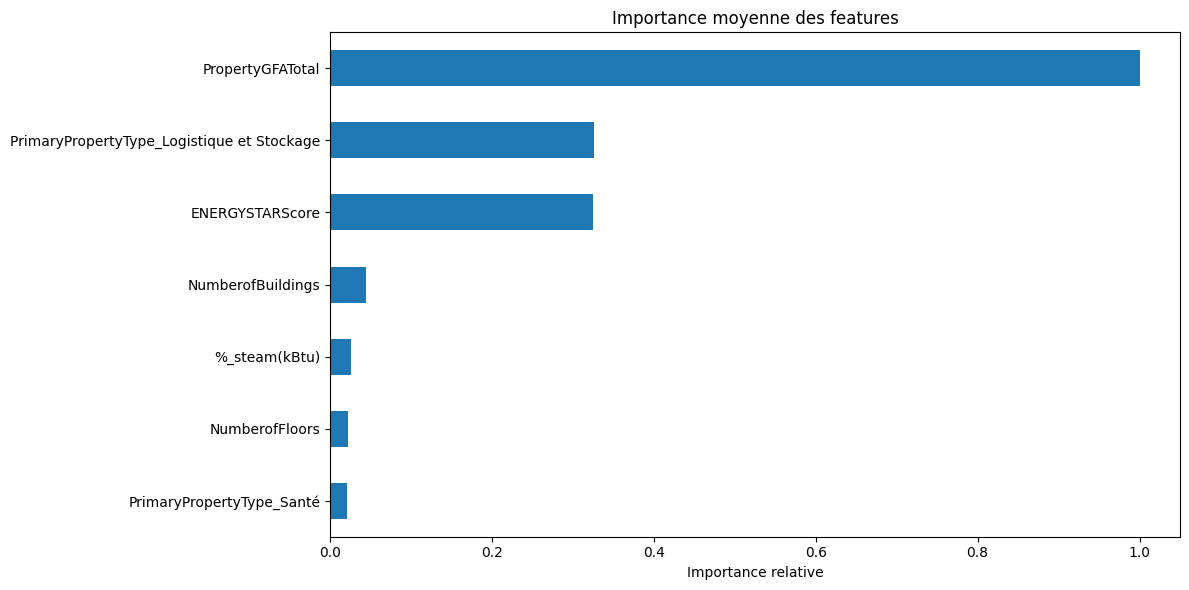

In [3563]:
models=[ridge,lasso,elastic_log]
model_names=['Ridge','Lasso','ElasticNet']


# Utilisation de la fonction
importance_analysis,_ = analyze_feature_importance(models, model_names, col_num_sel_regu_energy)

ENERGY STAR SCORE SE HISSE A LA TROISIEME PLACE DES FEATURES LES PLUS IMPORTANTES DANS NOTRE MODELE DE REGRESSION REGULARISEE


## RANDOM FOREST

In [3564]:
DF_cleaned_Energy=DF_cleaned.loc[~DF_cleaned['ENERGYSTARScore'].isna()]
DF_cleaned_Energy.shape

(979, 36)

In [3565]:
rfreg_energy,Tableau_score_mae_,Tableau_score_mape_,Tableau_score_mse_,Tableau_score_r2_=\
random_forest(DF_cleaned_Energy,col_num_sel_rf,TARGET,'log_target_feature',['PropertyGFATotal']
              ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2,True,best_params_rf)

Score R² train : 0.59
Score R² test : 0.62
Score MAE train : 3.49e+06
Score MAE test : 3.52e+06
Score MAPE train : 42.84 %
Score MAPE test : 51.48 %
Score MSE train : 2.32e+14
Score MSE test : 6.96e+13


In [3566]:
rfreg_Energy,Tableau_score_mae_,Tableau_score_mape_,Tableau_score_mse_,Tableau_score_r2_=\
random_forest(DF_cleaned_Energy,col_num_sel_rf_energy,TARGET,'log_target_feature',['PropertyGFATotal']
              ,Tableau_score_mae,Tableau_score_mape,Tableau_score_mse,Tableau_score_r2,True,best_params_rf)

Score R² train : 0.59
Score R² test : 0.64
Score MAE train : 3.14e+06
Score MAE test : 3.18e+06
Score MAPE train : 32.25 %
Score MAPE test : 38.94 %
Score MSE train : 2.28e+14
Score MSE test : 6.71e+13


POUR LE RANDOM FOREST ON CONSTATE UNE LEGERE AMELIORATION DES DIFFERENTES METRIQUES

In [3567]:
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split

X=DF_cleaned_Energy[col_num_sel_rf_energy]
y=DF_cleaned_Energy[TARGET]

X['PropertyGFATotal']=np.log(X['PropertyGFATotal'])
y=np.log(y)


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Calcul des permutation importances
result = permutation_importance(
   rfreg_Energy, 
   X_test,  # On utilise le jeu de test pour éviter le biais
   y_test,
   n_repeats=10,  # Nombre de permutations à effectuer
   random_state=42
)

# Création d'un dictionnaire avec les importances moyennes
importances = result.importances_mean
feature_names = X_test.columns
importances_dict = dict(zip(feature_names, importances))

# Tri par importance décroissante
sorted_importances = dict(sorted(importances_dict.items(), key=lambda x: x[1], reverse=True))

col_num_sel_rf=[]

# Affichage des résultats avec les écarts-types
for feature, importance in sorted_importances.items():
   std = result.importances_std[list(feature_names).index(feature)]
   print(f"{feature}: {importance:.4f} (±{std:.4f})")
   if importance>0.02 and feature not in ['AGE','OSEBuildingID']:
      col_num_sel_rf.append(feature)

PropertyGFATotal: 1.6099 (±0.1105)
ENERGYSTARScore: 0.1656 (±0.0184)
PrimaryPropertyType_Logistique et Stockage: 0.1399 (±0.0182)
%_elec(kBtu): 0.0167 (±0.0034)
%_gas(kBtu): 0.0087 (±0.0041)
PrimaryPropertyType_Immobilier Commercial: 0.0065 (±0.0059)


ENERGY STAR SCORE SE RETROUVE ETRE LA SECONDE FEATURE LA PLUS IMPORTANTE DANS LE MODELE RANDOM FOREST